# Baseline models training

Notebook contains training and validation of XGBoost models without any previous experiments on data.  We check 5 different prediction cases:
- All cancer types together, multiclass classification (stages: I, II, III, IV)
- All cancer types together, binary classification (stages: I-III vs IV)
- All cancer types together, binary classification (stages: I-II vs III-IV)
- Only the most numerous types of cancer (each one separately), multiclass classification (stages: I, II, III, IV)
- Only the most numerous types of cancer (each one separately), binary classification (stages: I-III vs IV)

Outcomes can be treated as baseline results.

In [1]:
import os
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

Define random seed to allow reproducibility

In [2]:
random_state = 42
np.random.seed(random_state)

Define directory paths to save results

In [3]:
output_dir_multiclass = '../results/updated_data/all_features/PDAC/baseline_models/multiclass/'
output_dir_binary = '../results/updated_data/all_features/PDAC/baseline_models/binary/'
output_dir_binary_2 = '../results/updated_data/all_features/PDAC/baseline_models/binary_I-II_vs_III-IV/'

Load training data

In [4]:
data_path = '../data/cleaned/updated/all_features/PDAC/'
models_path = '../models'

train = pd.read_csv(os.path.join(data_path, 'train.csv'), sep=';')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Columns: 5331 entries, ID to CASC15
dtypes: float64(5327), object(4)
memory usage: 3.8+ MB


Define functions for cross-validation in a stratified way: one for hyperparameters optimization (returns only mean score) and a second for validation of the model with best params (returns predictions)

In [5]:
def stratified_cross_val_score(
        estimator,
        df,
        stratification_groups,
        label_col,
        scoring,
        n_splits=5
):
    scores = np.zeros(n_splits)
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (train_index, test_index) in enumerate(skf.split(df, stratification_groups)):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)

        y_true = y.iloc[test_index]
        y_pred = estimator.predict(X.iloc[test_index])
        scores[i] = scoring(list(y_true), y_pred)

    return scores


def stratified_cross_val_predict(
        estimator,
        df,
        stratification_groups,
        label_col,
        n_splits=5
):
    y_pred = np.zeros(len(df))
    skf = StratifiedKFold(n_splits=n_splits)

    for train_index, test_index in skf.split(df, stratification_groups):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)
        y_pred[test_index] = estimator.predict(X.iloc[test_index])

    return y_pred

Define objective function for hyperparameters optimization using Optuna

In [6]:
def objective(trial: optuna.Trial, X_train, stratification_groups, xgb_config, scoring):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        **xgb_config
    }

    xgb = XGBClassifier(**params)

    scores = stratified_cross_val_score(
        estimator=xgb,
        df=X_train,
        stratification_groups=stratification_groups,
        label_col='Stage',
        scoring=scoring,
        n_splits=4
    )

    return scores.mean()

Define function for plotting confusion matrix

In [7]:
def plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=None):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', linewidths=1)
    plt.setp(plt.gca().get_xticklabels(), ha='right', rotation=45)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.title(title, y=1.12, fontsize=12)
    plt.suptitle(scores_subtitle, y=0.08, fontsize=12)

    fig.show()
    
    if output_path is not None:
        fig.savefig(output_path, bbox_inches='tight')

### All cancer types together, multiclass classification (stages: I, II, III, IV)

Extract cancer types and stages to perform cross validation in a stratified way

Remove unnecessary columns: ID, Group, Sex and Age

Encode labels

In [8]:
X_train = train.copy(deep=True)

stratification_groups = X_train.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
cancer_types = X_train['Group']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

labels_encoding = {
    'I': 0,
    'II': 1,
    'III': 2,
    'IV': 3
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)

X_train['Stage'].value_counts()

1    49
2    23
3    19
0     2
Name: Stage, dtype: int64

Since the classes are pretty imbalanced we use the weighted-average F1 metric for optimization

In [9]:
xgb_config = {
    'objective': 'multi:softmax',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
    'num_class': 4,
}

objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-25 18:55:43,981] A new study created in memory with name: no-name-ecae79c8-1371-419e-91f4-c74270c78760
[I 2023-10-25 18:55:54,037] Trial 0 finished with value: 0.28378739316239315 and parameters: {'n_estimators': 62, 'max_depth': 2, 'learning_rate': 0.00598264552754596, 'subsample': 0.86720585831692, 'colsample_bytree': 0.5973394548007258, 'gamma': 3.676049089785613}. Best is trial 0 with value: 0.28378739316239315.
[I 2023-10-25 18:56:07,754] Trial 1 finished with value: 0.2390491452991453 and parameters: {'n_estimators': 126, 'max_depth': 6, 'learning_rate': 0.39722118848534, 'subsample': 0.7154683891418401, 'colsample_bytree': 0.8054336612661286, 'gamma': 4.410018061693945}. Best is trial 0 with value: 0.28378739316239315.
[I 2023-10-25 18:56:15,509] Trial 2 finished with value: 0.25448717948717947 and parameters: {'n_estimators': 53, 'max_depth': 2, 'learning_rate': 0.24119627823372872, 'subsample': 0.9397099892885739, 'colsample_bytree': 0.7360350608172058, 'gamma': 1.2

[I 2023-10-25 19:00:37,198] Trial 25 finished with value: 0.29877136752136746 and parameters: {'n_estimators': 107, 'max_depth': 5, 'learning_rate': 0.28923387527414485, 'subsample': 0.834950773849151, 'colsample_bytree': 0.8467290441653625, 'gamma': 2.890530029474493}. Best is trial 21 with value: 0.35838675213675214.
[I 2023-10-25 19:00:51,714] Trial 26 finished with value: 0.2793269230769231 and parameters: {'n_estimators': 133, 'max_depth': 6, 'learning_rate': 0.24565953131892357, 'subsample': 0.763956413712656, 'colsample_bytree': 0.8484154415066362, 'gamma': 3.262581927276066}. Best is trial 21 with value: 0.35838675213675214.
[I 2023-10-25 19:01:02,453] Trial 27 finished with value: 0.2998130341880342 and parameters: {'n_estimators': 84, 'max_depth': 4, 'learning_rate': 0.2107711426315737, 'subsample': 0.7046446943350799, 'colsample_bytree': 0.7604830410381671, 'gamma': 3.6347251226103454}. Best is trial 21 with value: 0.35838675213675214.
[I 2023-10-25 19:01:16,245] Trial 28 fi

[I 2023-10-25 19:06:07,320] Trial 50 finished with value: 0.2465010683760684 and parameters: {'n_estimators': 89, 'max_depth': 6, 'learning_rate': 0.4906865339650765, 'subsample': 0.6620196631673334, 'colsample_bytree': 0.9336525011468256, 'gamma': 1.870598201423891}. Best is trial 21 with value: 0.35838675213675214.
[I 2023-10-25 19:06:20,320] Trial 51 finished with value: 0.3282852564102564 and parameters: {'n_estimators': 112, 'max_depth': 6, 'learning_rate': 0.3675108724972607, 'subsample': 0.6856767223824479, 'colsample_bytree': 0.8265185133345653, 'gamma': 2.5159753755597096}. Best is trial 21 with value: 0.35838675213675214.
[I 2023-10-25 19:06:33,282] Trial 52 finished with value: 0.31092414529914525 and parameters: {'n_estimators': 112, 'max_depth': 7, 'learning_rate': 0.37531422574251455, 'subsample': 0.6844203288538907, 'colsample_bytree': 0.8386413946290979, 'gamma': 2.1766928110417307}. Best is trial 21 with value: 0.35838675213675214.
[I 2023-10-25 19:06:46,719] Trial 53 

[I 2023-10-25 19:12:19,317] Trial 75 finished with value: 0.2987713675213675 and parameters: {'n_estimators': 112, 'max_depth': 6, 'learning_rate': 0.3682599273937427, 'subsample': 0.7147784164820965, 'colsample_bytree': 0.9487032404258242, 'gamma': 2.5935492323426197}. Best is trial 21 with value: 0.35838675213675214.
[I 2023-10-25 19:12:36,678] Trial 76 finished with value: 0.328926282051282 and parameters: {'n_estimators': 119, 'max_depth': 5, 'learning_rate': 0.3212981759124196, 'subsample': 0.6398220448952036, 'colsample_bytree': 0.8288147017064957, 'gamma': 1.4687112119040537}. Best is trial 21 with value: 0.35838675213675214.
[I 2023-10-25 19:12:53,609] Trial 77 finished with value: 0.34281517094017094 and parameters: {'n_estimators': 115, 'max_depth': 5, 'learning_rate': 0.29903296982634703, 'subsample': 0.637813674548871, 'colsample_bytree': 0.8277227604606587, 'gamma': 1.8518321137823714}. Best is trial 21 with value: 0.35838675213675214.
[I 2023-10-25 19:13:11,130] Trial 78 

Extract the best of the found hyperparameters and perform cross validation on the whole training set

In [10]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.00      0.00      0.00         2
          II       0.53      0.80      0.64        49
         III       0.17      0.09      0.11        23
          IV       0.25      0.11      0.15        19

    accuracy                           0.46        93
   macro avg       0.24      0.25      0.23        93
weighted avg       0.37      0.46      0.40        93



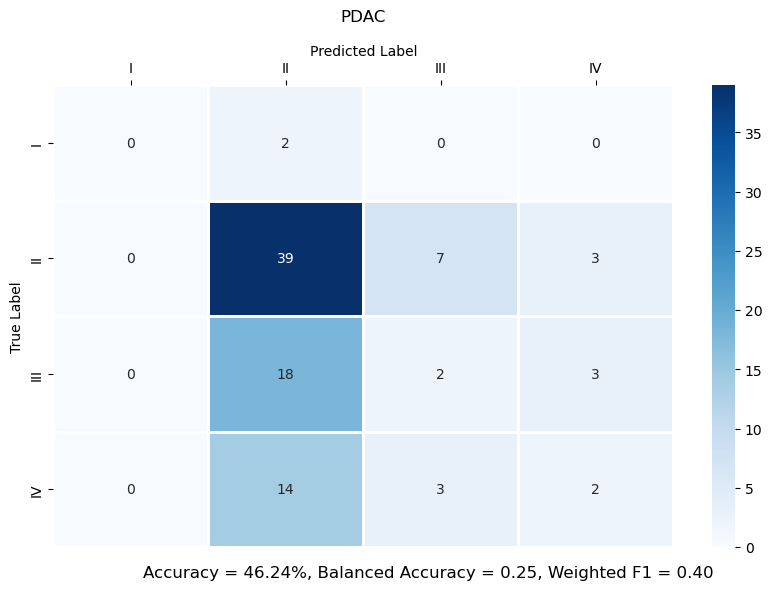

In [11]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'PDAC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'baseline.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

Check model performance for each cancer type separately

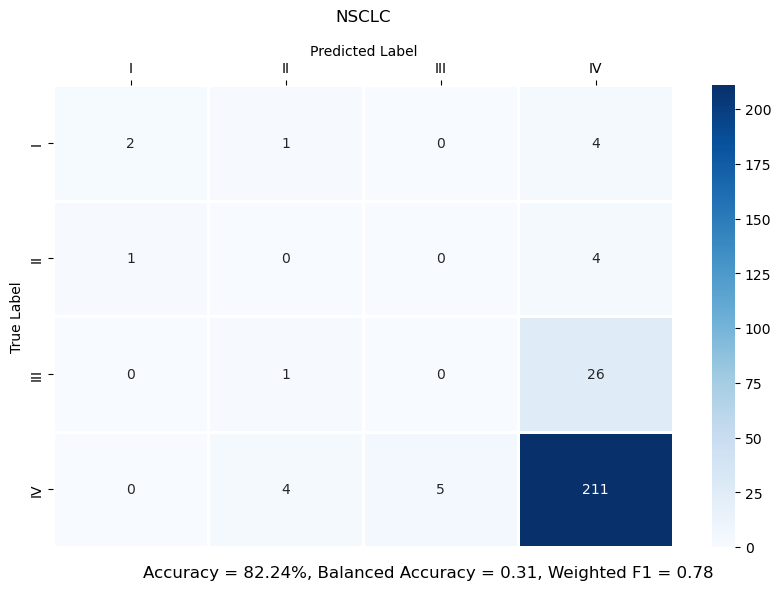

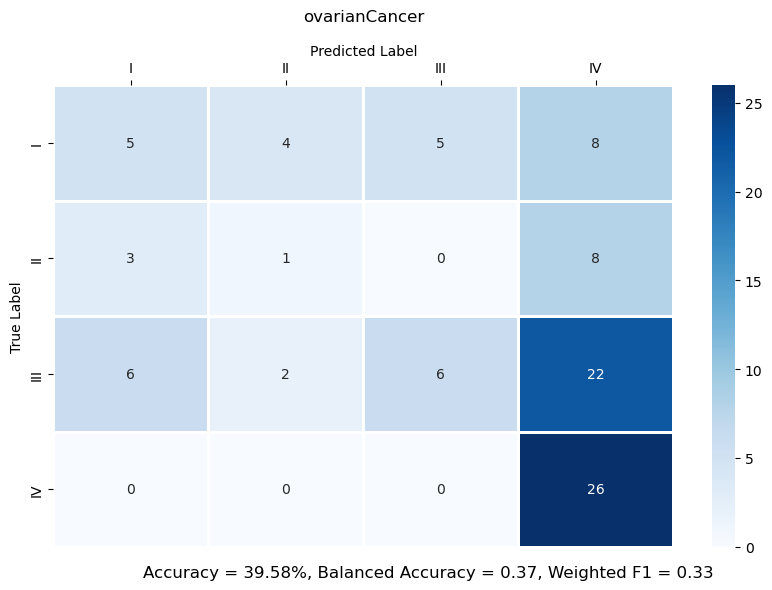

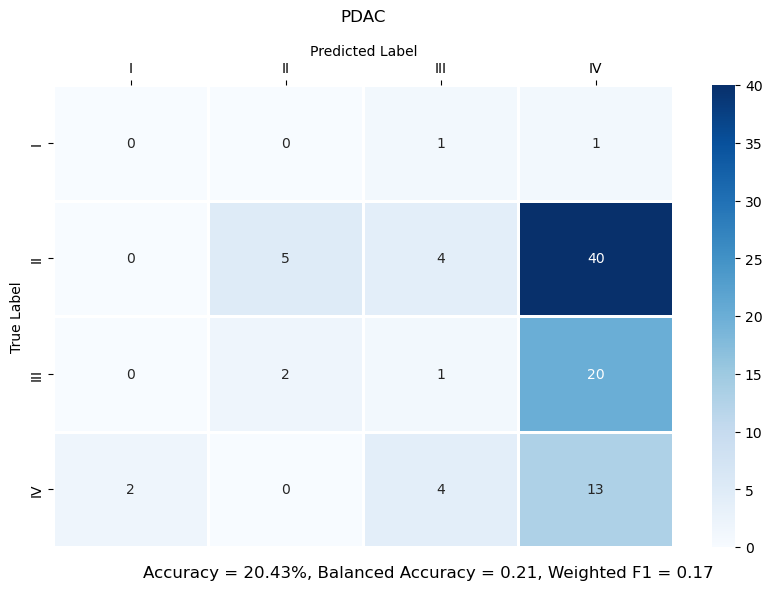

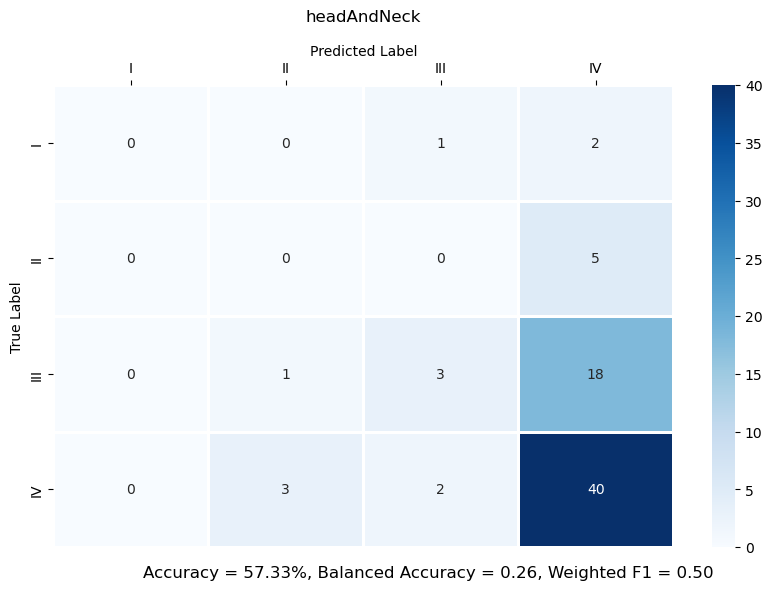

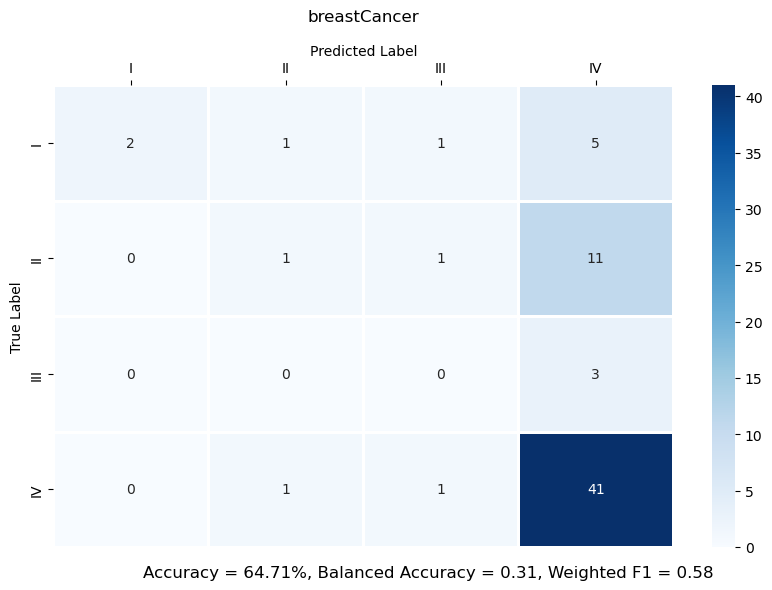

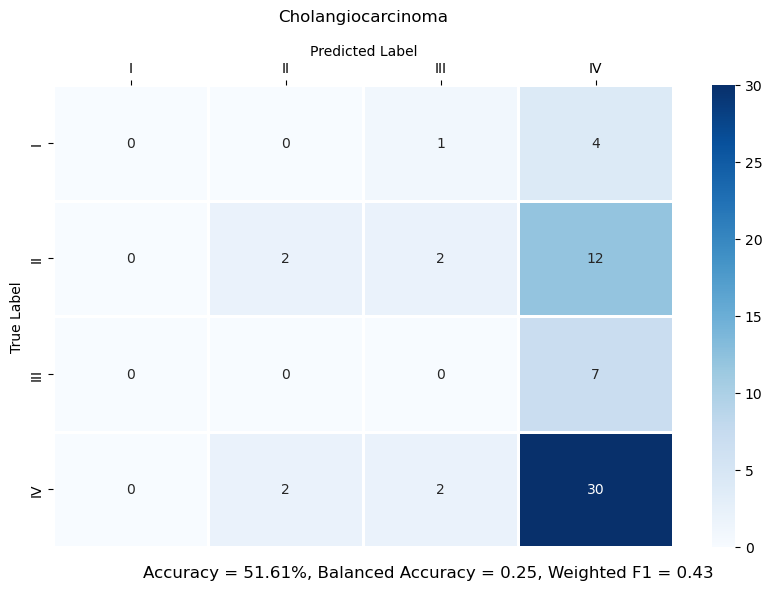

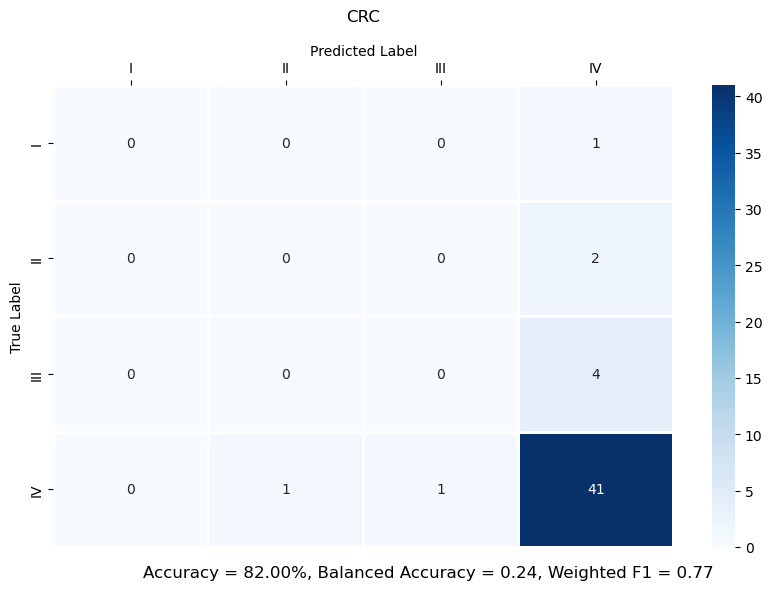

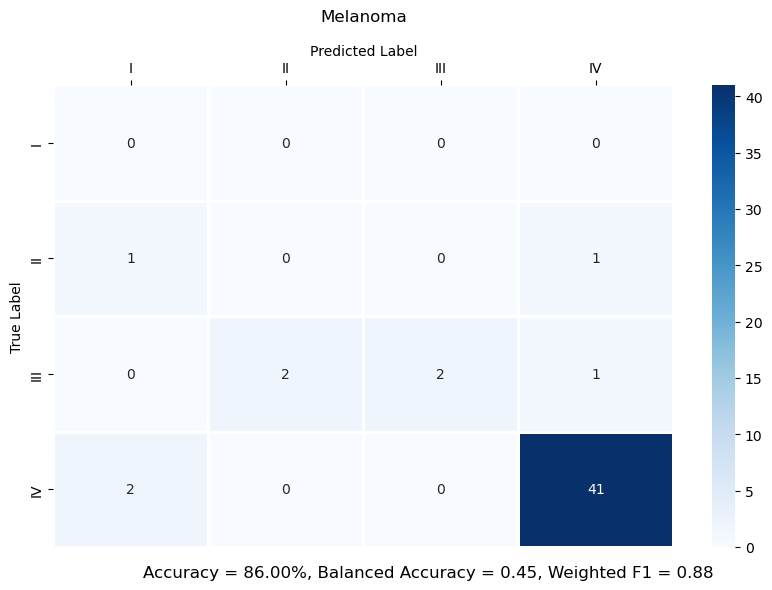

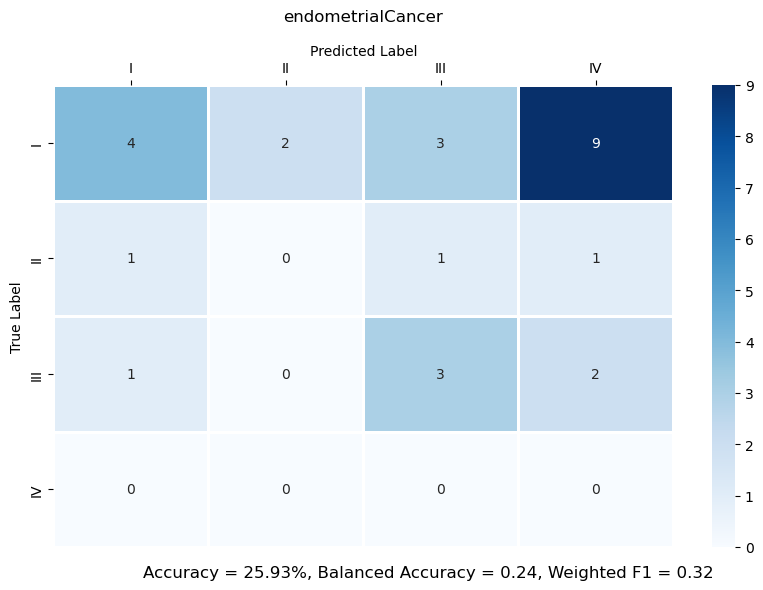

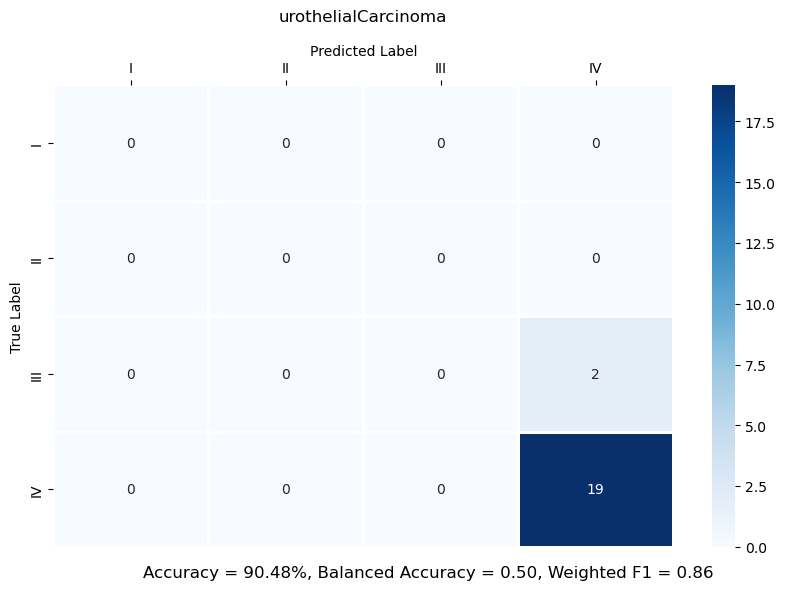

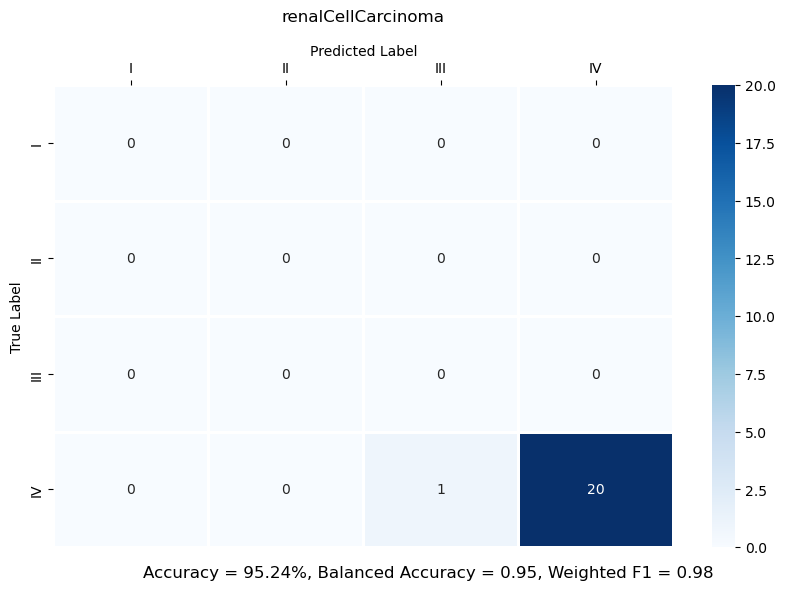

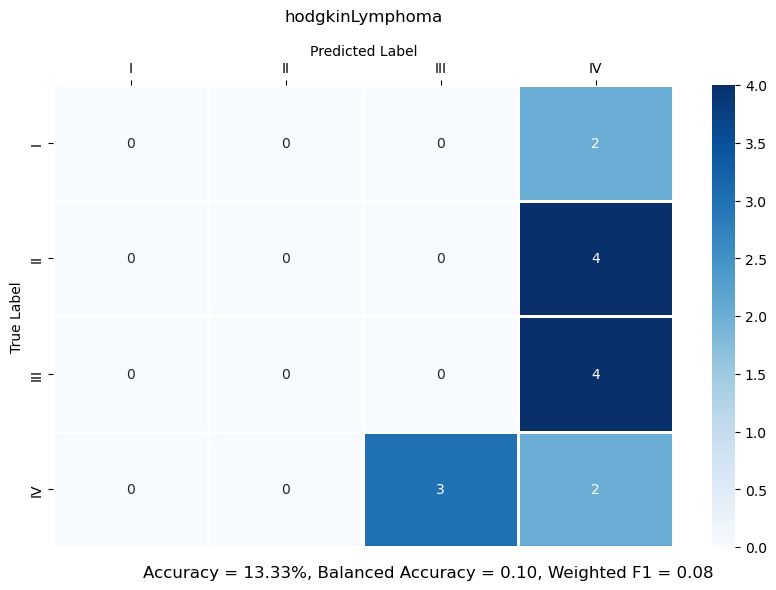

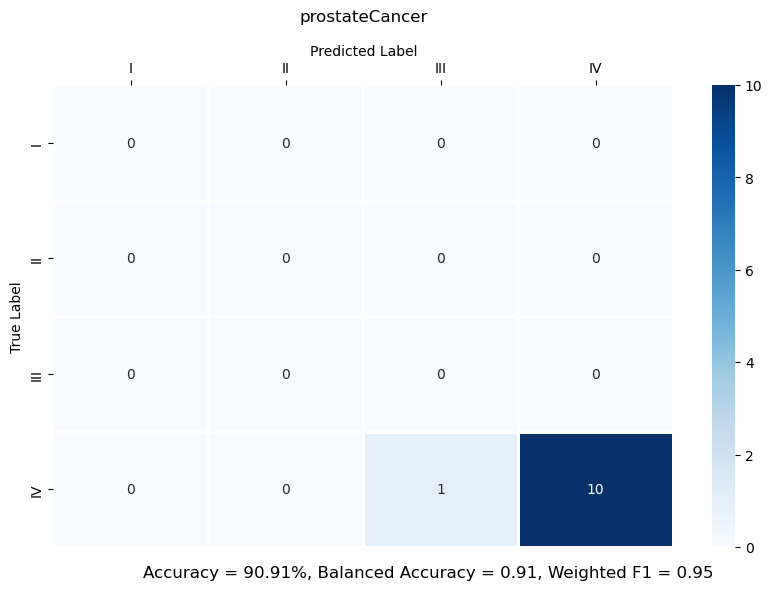

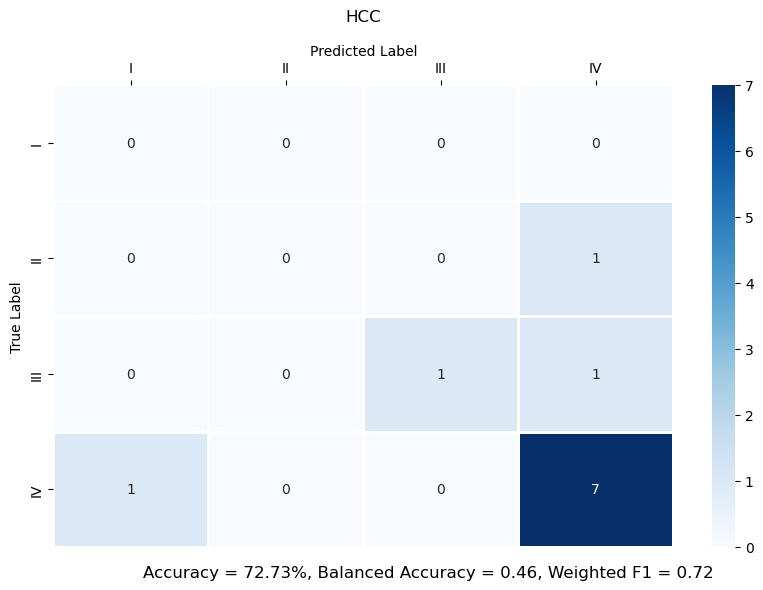

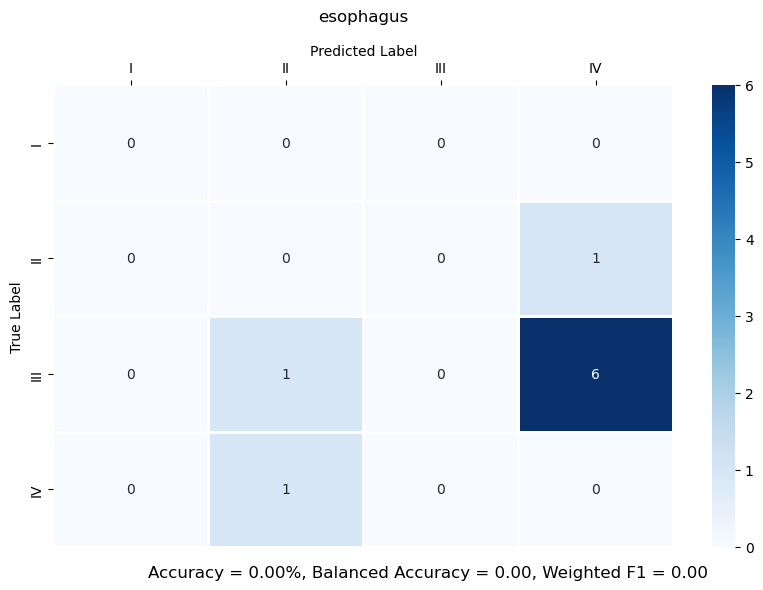

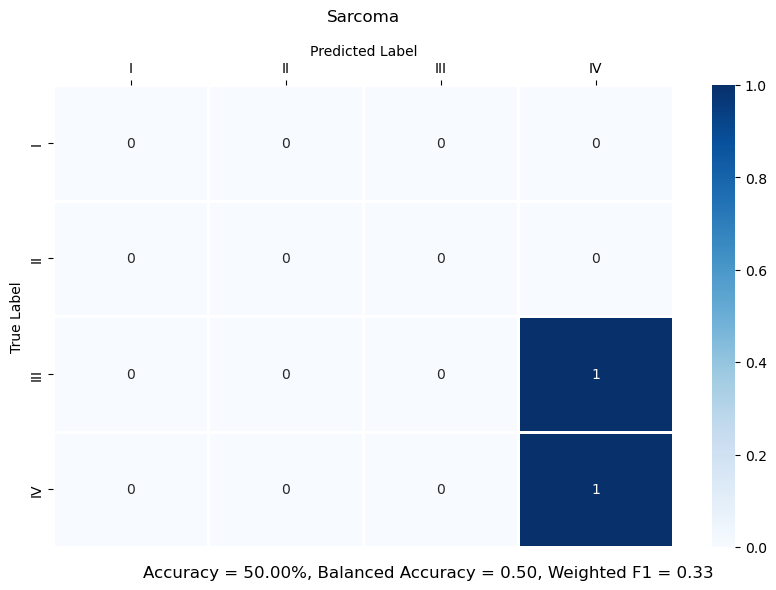

In [12]:
results = pd.DataFrame({
    'group': cancer_types,
    'y_true': y_true,
    'y_pred': y_pred.astype(int)
})

group_names = cancer_types.value_counts().index

for group_name in group_names:
    sub_results = results.loc[results['group'] == group_name]

    accuracy = accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    balanced_accuracy = balanced_accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    f1 = f1_score(sub_results['y_true'], sub_results['y_pred'], average='weighted')
    cm = confusion_matrix(sub_results['y_true'], sub_results['y_pred'], labels=[0, 1, 2, 3])

    title = group_name
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

    filename = f'all_cancer_types_only_{group_name.lower().replace(" ", "_")}_results.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

## All cancer types together, binary classification (stages: I-III vs IV)

Map first three stages to one mutual class "I-III"

Encode labels

In [12]:
X_train = train.copy(deep=True)

mapping = {
    'I': 'I-III',
    'II': 'I-III',
    'III': 'I-III',
    'IV': 'IV'
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping)

stratification_groups = X_train.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
cancer_types = X_train['Group']
X_train = X_train.loc[:, ~train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

labels_encoding = {
    'I-III': 0,
    'IV': 1
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)

X_train['Stage'].value_counts()

0    74
1    19
Name: Stage, dtype: int64

Run hyperparameters optimization

In [13]:
xgb_config = {
    'objective': 'binary:logistic',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
}

objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-25 19:19:32,004] A new study created in memory with name: no-name-510d6ba4-4106-4937-9d54-8a97ac8c9217
[I 2023-10-25 19:19:38,825] Trial 0 finished with value: 0.47748538011695907 and parameters: {'n_estimators': 36, 'max_depth': 6, 'learning_rate': 0.4065138553894193, 'subsample': 0.5369021370922082, 'colsample_bytree': 0.8933978778154015, 'gamma': 2.385935276776858}. Best is trial 0 with value: 0.47748538011695907.
[I 2023-10-25 19:19:45,548] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 31, 'max_depth': 4, 'learning_rate': 0.03154854146834045, 'subsample': 0.5242824468823126, 'colsample_bytree': 0.720275196995768, 'gamma': 1.067070451458626}. Best is trial 1 with value: 0.5.
[I 2023-10-25 19:19:56,049] Trial 2 finished with value: 0.525 and parameters: {'n_estimators': 75, 'max_depth': 3, 'learning_rate': 0.23667138698970275, 'subsample': 0.8211463095349023, 'colsample_bytree': 0.531758785536935, 'gamma': 4.9144748252469865}. Best is trial 2 with value

[I 2023-10-25 19:24:37,476] Trial 25 finished with value: 0.5364766081871345 and parameters: {'n_estimators': 120, 'max_depth': 3, 'learning_rate': 0.2232332857505734, 'subsample': 0.5944036409670725, 'colsample_bytree': 0.9075932465660405, 'gamma': 0.9391246502715196}. Best is trial 13 with value: 0.5410087719298244.
[I 2023-10-25 19:24:50,529] Trial 26 finished with value: 0.50453216374269 and parameters: {'n_estimators': 110, 'max_depth': 2, 'learning_rate': 0.1901814558394545, 'subsample': 0.725486239286473, 'colsample_bytree': 0.9726208030282563, 'gamma': 1.682897022010306}. Best is trial 13 with value: 0.5410087719298244.
[I 2023-10-25 19:25:05,900] Trial 27 finished with value: 0.50453216374269 and parameters: {'n_estimators': 136, 'max_depth': 4, 'learning_rate': 0.3320361803399647, 'subsample': 0.6784674490520904, 'colsample_bytree': 0.9425595062234615, 'gamma': 0.5081045820150658}. Best is trial 13 with value: 0.5410087719298244.
[I 2023-10-25 19:25:17,989] Trial 28 finished 

[I 2023-10-25 19:30:16,629] Trial 50 finished with value: 0.48647660818713445 and parameters: {'n_estimators': 125, 'max_depth': 3, 'learning_rate': 0.19582010818771373, 'subsample': 0.6863507007411896, 'colsample_bytree': 0.8829652711473273, 'gamma': 0.24951954385626096}. Best is trial 28 with value: 0.5680555555555555.
[I 2023-10-25 19:30:32,672] Trial 51 finished with value: 0.5048976608187135 and parameters: {'n_estimators': 142, 'max_depth': 2, 'learning_rate': 0.22857518996719034, 'subsample': 0.711959402149142, 'colsample_bytree': 0.9975469713510038, 'gamma': 0.04990666935649524}. Best is trial 28 with value: 0.5680555555555555.
[I 2023-10-25 19:30:48,226] Trial 52 finished with value: 0.45906432748538006 and parameters: {'n_estimators': 135, 'max_depth': 6, 'learning_rate': 0.25448323299727854, 'subsample': 0.6697109366157377, 'colsample_bytree': 0.9840082219759374, 'gamma': 0.24531939485106635}. Best is trial 28 with value: 0.5680555555555555.
[I 2023-10-25 19:31:03,315] Trial

[I 2023-10-25 19:36:08,588] Trial 75 finished with value: 0.5184210526315789 and parameters: {'n_estimators': 132, 'max_depth': 2, 'learning_rate': 0.17911938133520272, 'subsample': 0.5978976798432939, 'colsample_bytree': 0.9489861149533604, 'gamma': 1.0747591798523803}. Best is trial 28 with value: 0.5680555555555555.
[I 2023-10-25 19:36:20,276] Trial 76 finished with value: 0.5364766081871345 and parameters: {'n_estimators': 96, 'max_depth': 2, 'learning_rate': 0.21938834547357794, 'subsample': 0.6204175153595263, 'colsample_bytree': 0.8801324151963404, 'gamma': 2.0820663246237725}. Best is trial 28 with value: 0.5680555555555555.
[I 2023-10-25 19:36:34,176] Trial 77 finished with value: 0.5111111111111112 and parameters: {'n_estimators': 117, 'max_depth': 3, 'learning_rate': 0.29372397212618456, 'subsample': 0.6550511870443828, 'colsample_bytree': 0.9779927181152884, 'gamma': 0.11037687214233088}. Best is trial 28 with value: 0.5680555555555555.
[I 2023-10-25 19:36:48,786] Trial 78 

Extract the best of the found hyperparameters and perform cross validation on the whole training set

In [14]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.79      0.91      0.84        74
          IV       0.12      0.05      0.07        19

    accuracy                           0.73        93
   macro avg       0.46      0.48      0.46        93
weighted avg       0.65      0.73      0.69        93



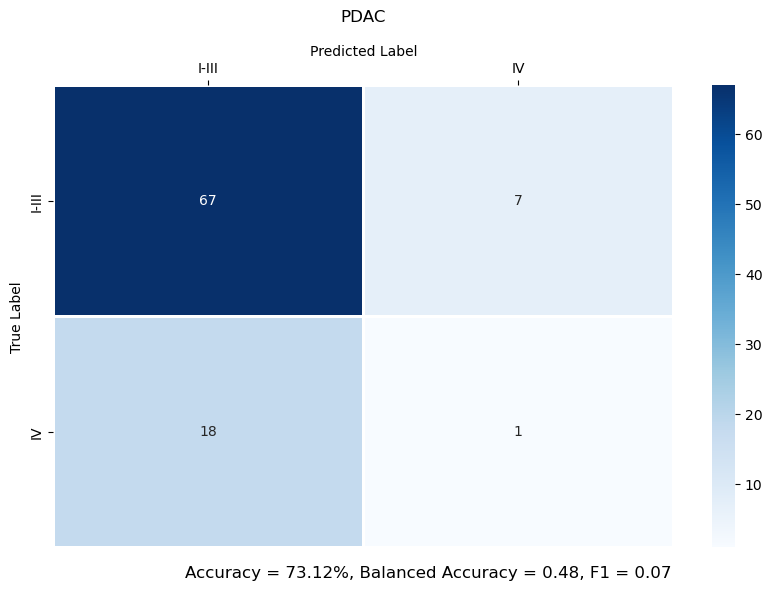

In [15]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'PDAC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, F1 = {f1:.2f}'

filename = f'baseline.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

Check model performance for each cancer type separately

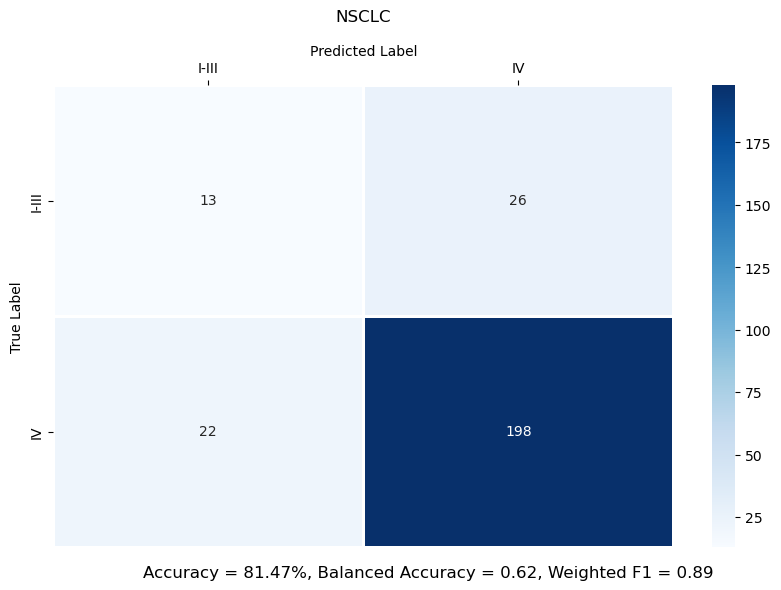

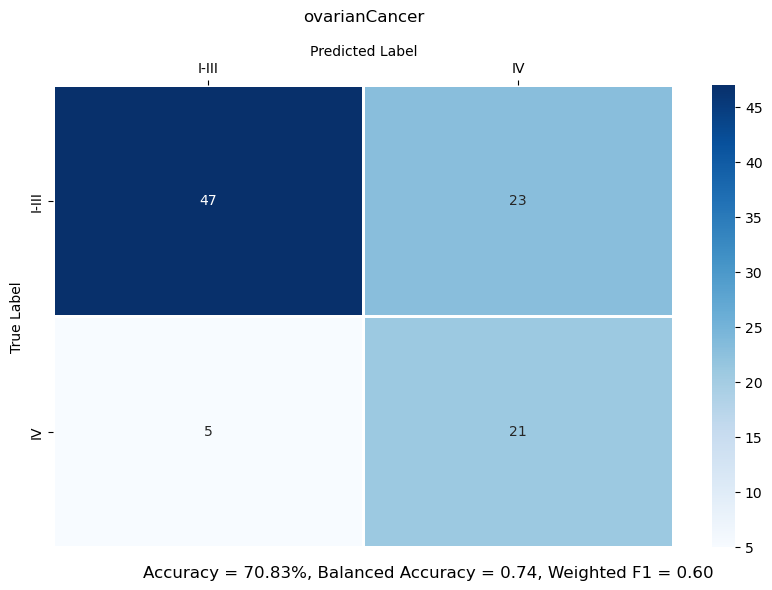

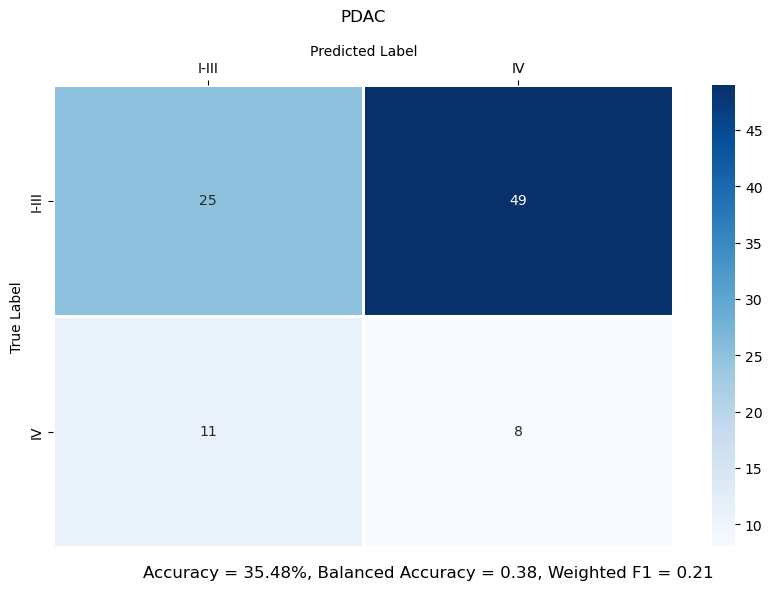

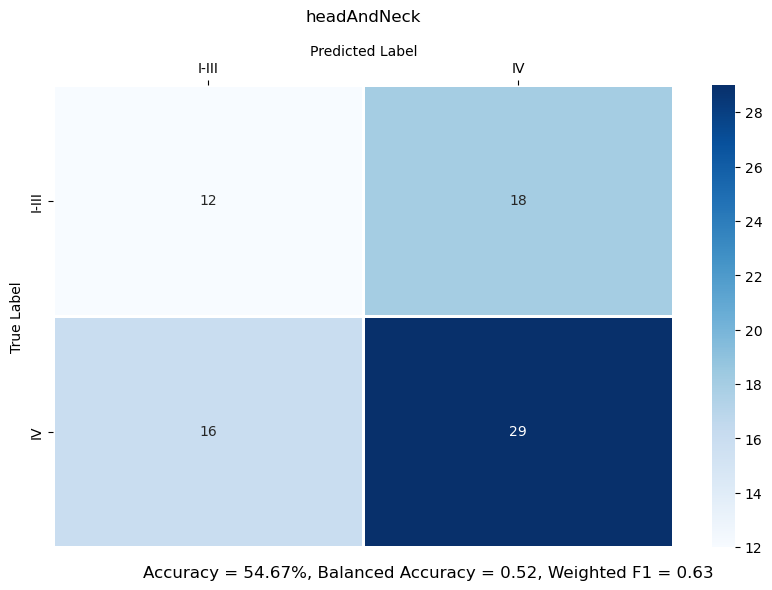

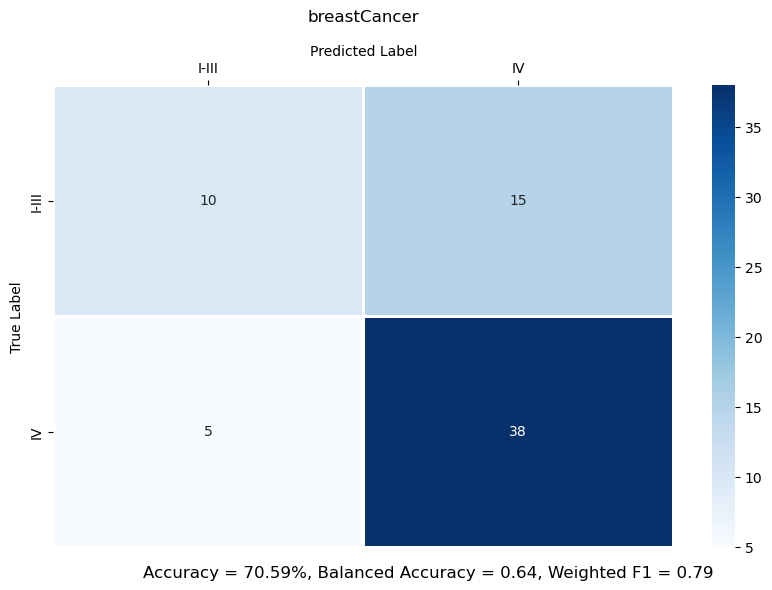

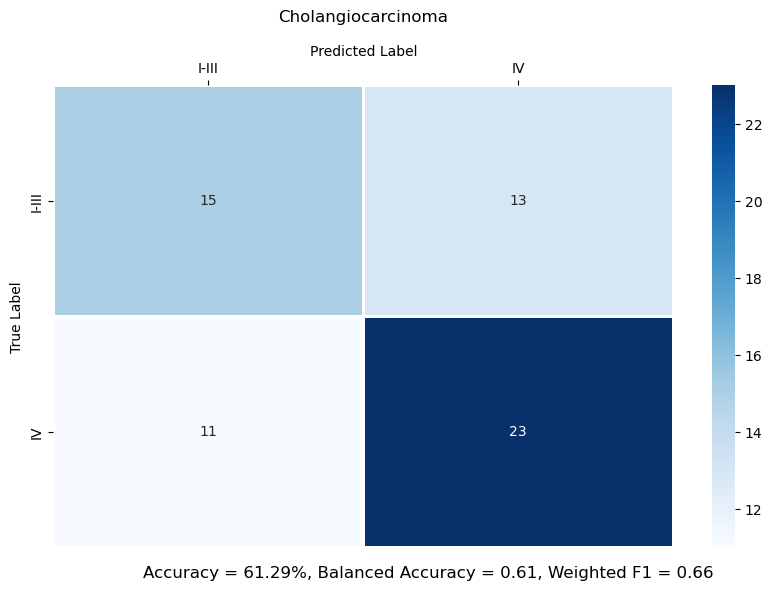

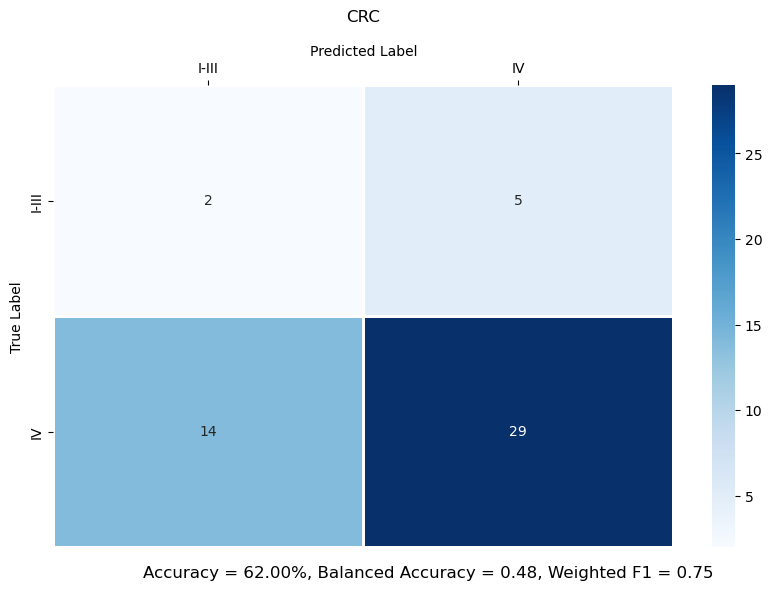

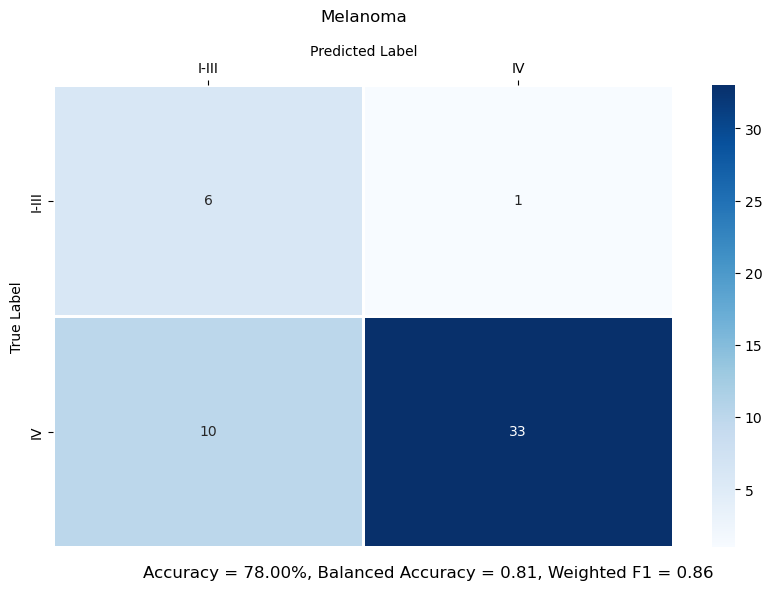

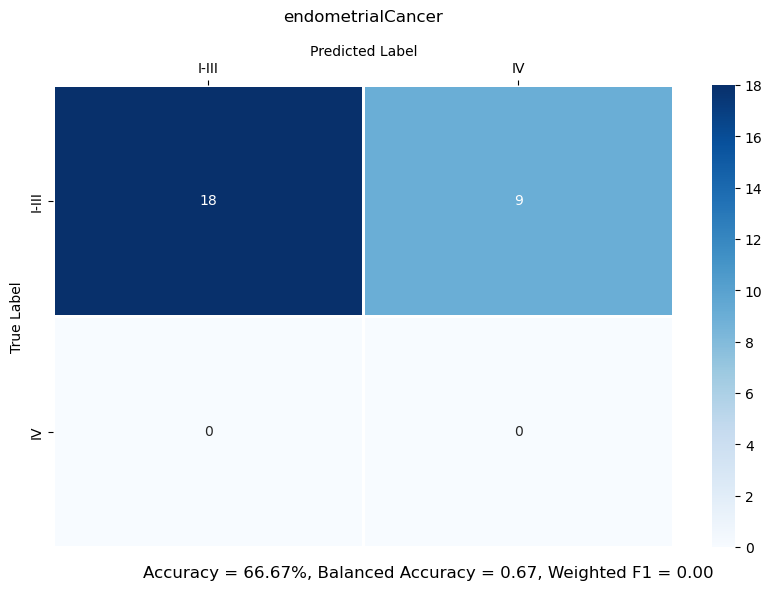

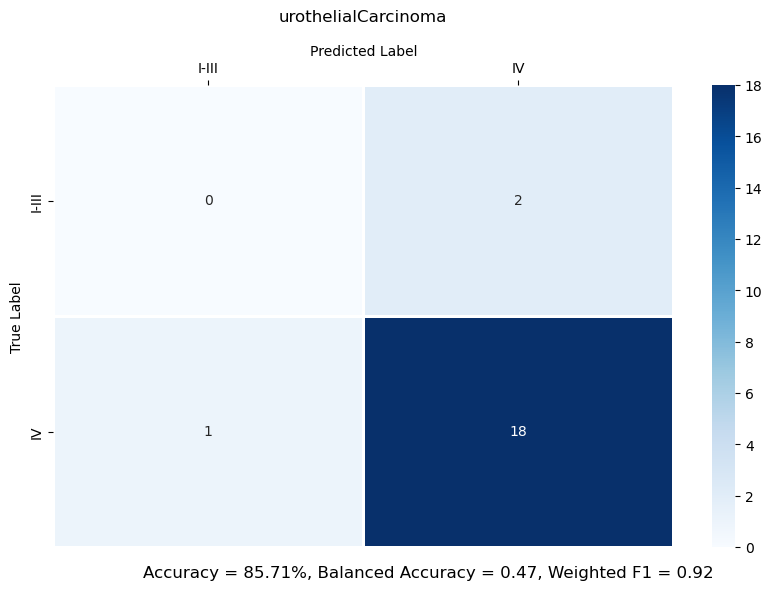

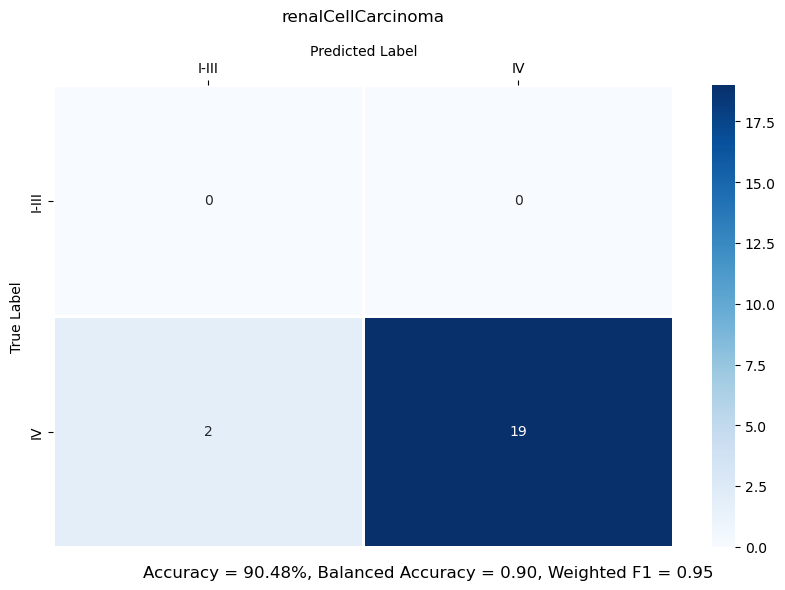

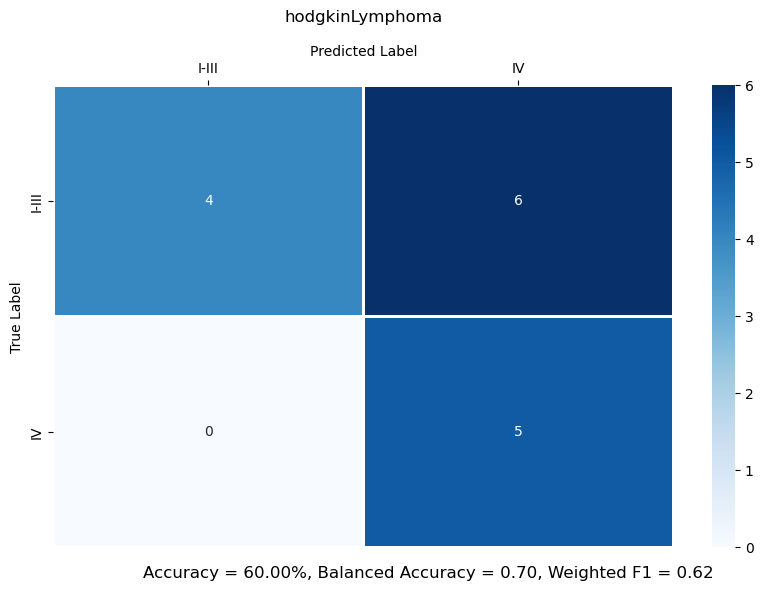

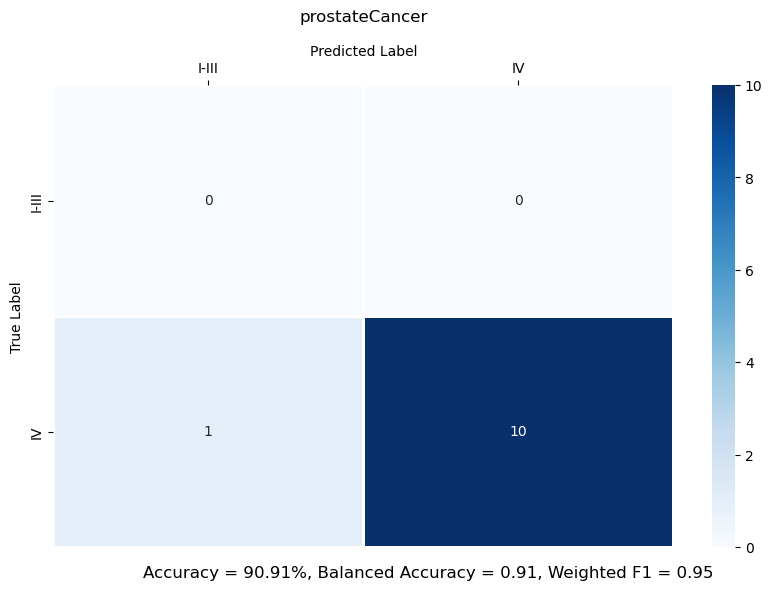

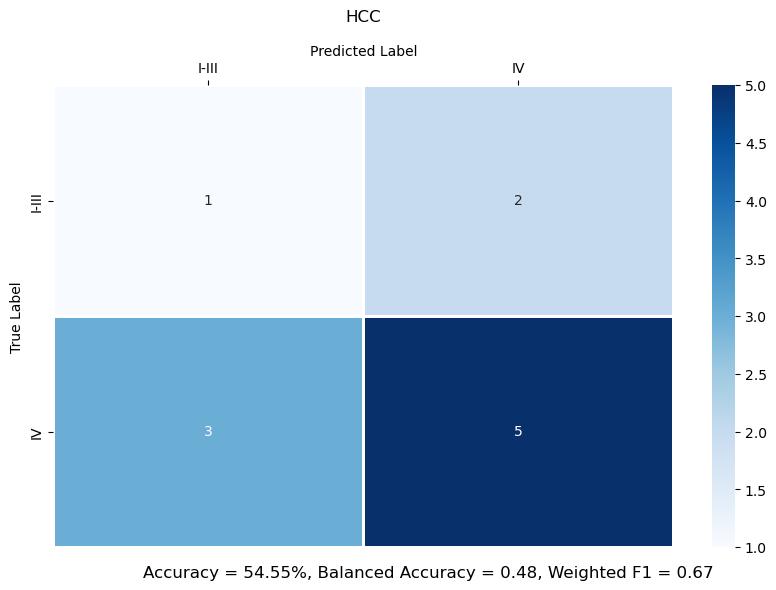

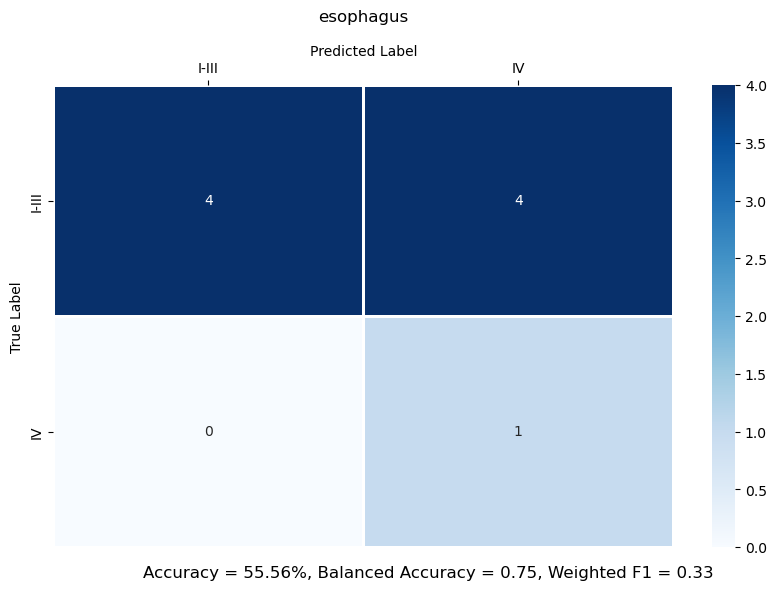

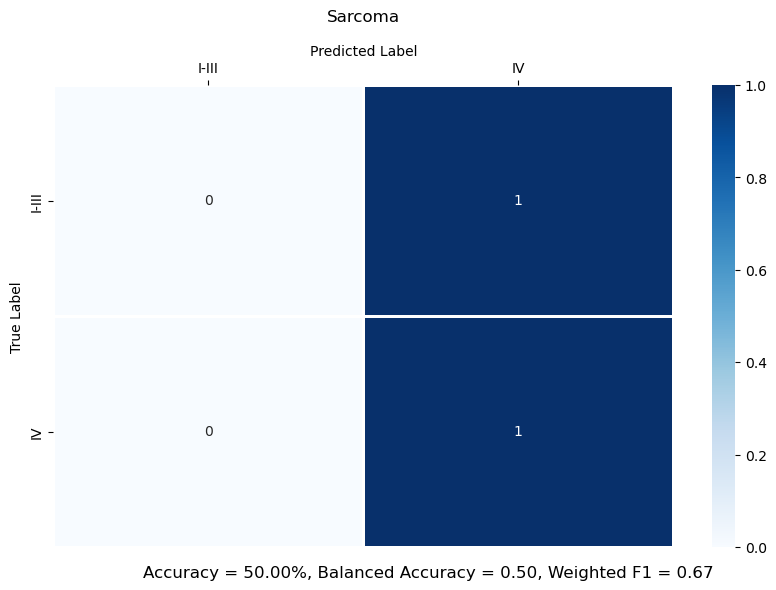

In [17]:
results = pd.DataFrame({
    'group': cancer_types,
    'y_true': y_true,
    'y_pred': y_pred.astype(int)
})

group_names = cancer_types.value_counts().index

for group_name in group_names:
    sub_results = results.loc[results['group'] == group_name]

    accuracy = accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    balanced_accuracy = balanced_accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    f1 = f1_score(sub_results['y_true'], sub_results['y_pred'])
    cm = confusion_matrix(sub_results['y_true'], sub_results['y_pred'], labels=[0, 1])

    title = group_name
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

    filename = f'all_cancer_types_only_{group_name.lower().replace(" ", "_")}_results.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

## All cancer types together, binary classification (stages: I-II vs III-IV)

Map stages to two mutual classes

Encode labels

In [16]:
X_train = train.copy(deep=True)

mapping = {
    'I': 'I-II',
    'II': 'I-II',
    'III': 'III-IV',
    'IV': 'III-IV'
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping)

stratification_groups = X_train.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
cancer_types = X_train['Group']
X_train = X_train.loc[:, ~train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

labels_encoding = {
    'I-II': 0,
    'III-IV': 1
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)

X_train['Stage'].value_counts()

0    51
1    42
Name: Stage, dtype: int64

Run hyperparameters optimization

In [17]:
xgb_config = {
    'objective': 'binary:logistic',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
}

objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-25 19:42:38,716] A new study created in memory with name: no-name-d857d563-cf13-4b2d-8747-9b833f1a370b
[I 2023-10-25 19:42:49,379] Trial 0 finished with value: 0.6500291375291376 and parameters: {'n_estimators': 81, 'max_depth': 8, 'learning_rate': 0.4158742585446628, 'subsample': 0.9729020960704156, 'colsample_bytree': 0.7273655354946875, 'gamma': 4.805872153164955}. Best is trial 0 with value: 0.6500291375291376.
[I 2023-10-25 19:42:55,920] Trial 1 finished with value: 0.5000437062937063 and parameters: {'n_estimators': 29, 'max_depth': 7, 'learning_rate': 0.0460463749813264, 'subsample': 0.8452309126764466, 'colsample_bytree': 0.5307978336489102, 'gamma': 2.54094643280406}. Best is trial 0 with value: 0.6500291375291376.
[I 2023-10-25 19:43:12,123] Trial 2 finished with value: 0.560270979020979 and parameters: {'n_estimators': 133, 'max_depth': 4, 'learning_rate': 0.08430711687936715, 'subsample': 0.9774889242676328, 'colsample_bytree': 0.8822123077358315, 'gamma': 0.0246

[I 2023-10-25 19:47:15,007] Trial 25 finished with value: 0.5304487179487178 and parameters: {'n_estimators': 72, 'max_depth': 6, 'learning_rate': 0.11203419795004571, 'subsample': 0.8976828745430218, 'colsample_bytree': 0.7353925045553881, 'gamma': 4.447807204322178}. Best is trial 0 with value: 0.6500291375291376.
[I 2023-10-25 19:47:25,352] Trial 26 finished with value: 0.5679341491841492 and parameters: {'n_estimators': 86, 'max_depth': 7, 'learning_rate': 0.28152839166165206, 'subsample': 0.9536732334484133, 'colsample_bytree': 0.6765655883010279, 'gamma': 3.8912618809879627}. Best is trial 0 with value: 0.6500291375291376.
[I 2023-10-25 19:47:31,963] Trial 27 finished with value: 0.48323135198135203 and parameters: {'n_estimators': 33, 'max_depth': 8, 'learning_rate': 0.39102833271907783, 'subsample': 0.9627403797640268, 'colsample_bytree': 0.6981619986243008, 'gamma': 4.513049518240316}. Best is trial 0 with value: 0.6500291375291376.
[I 2023-10-25 19:47:42,567] Trial 28 finishe

[I 2023-10-25 19:50:52,774] Trial 50 finished with value: 0.5747086247086247 and parameters: {'n_estimators': 47, 'max_depth': 7, 'learning_rate': 0.390805291311012, 'subsample': 0.8634215926934539, 'colsample_bytree': 0.7818190924624876, 'gamma': 4.283656223756065}. Best is trial 0 with value: 0.6500291375291376.
[I 2023-10-25 19:50:58,980] Trial 51 finished with value: 0.5362762237762237 and parameters: {'n_estimators': 28, 'max_depth': 8, 'learning_rate': 0.3705792978162824, 'subsample': 0.939843027875236, 'colsample_bytree': 0.7331077762781942, 'gamma': 4.724846405575007}. Best is trial 0 with value: 0.6500291375291376.
[I 2023-10-25 19:51:06,419] Trial 52 finished with value: 0.5502039627039628 and parameters: {'n_estimators': 41, 'max_depth': 7, 'learning_rate': 0.32135500813736045, 'subsample': 0.9821750984287938, 'colsample_bytree': 0.7634678887890096, 'gamma': 4.749277675284324}. Best is trial 0 with value: 0.6500291375291376.
[I 2023-10-25 19:51:12,225] Trial 53 finished with

[I 2023-10-25 19:53:56,706] Trial 75 finished with value: 0.5690705128205128 and parameters: {'n_estimators': 34, 'max_depth': 6, 'learning_rate': 0.3135118390758159, 'subsample': 0.9447580783084396, 'colsample_bytree': 0.7584218939514503, 'gamma': 4.859489930257273}. Best is trial 0 with value: 0.6500291375291376.
[I 2023-10-25 19:54:03,418] Trial 76 finished with value: 0.5577214452214452 and parameters: {'n_estimators': 30, 'max_depth': 2, 'learning_rate': 0.40214622854567966, 'subsample': 0.9845126671333452, 'colsample_bytree': 0.7285425244865117, 'gamma': 4.436049771907168}. Best is trial 0 with value: 0.6500291375291376.
[I 2023-10-25 19:54:09,755] Trial 77 finished with value: 0.5462121212121211 and parameters: {'n_estimators': 25, 'max_depth': 6, 'learning_rate': 0.3402401240567085, 'subsample': 0.9165479814005918, 'colsample_bytree': 0.7786289135684831, 'gamma': 4.653421305570197}. Best is trial 0 with value: 0.6500291375291376.
[I 2023-10-25 19:54:17,349] Trial 78 finished wi

In [18]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

        I-II       0.52      0.53      0.52        51
      III-IV       0.41      0.40      0.41        42

    accuracy                           0.47        93
   macro avg       0.47      0.47      0.47        93
weighted avg       0.47      0.47      0.47        93



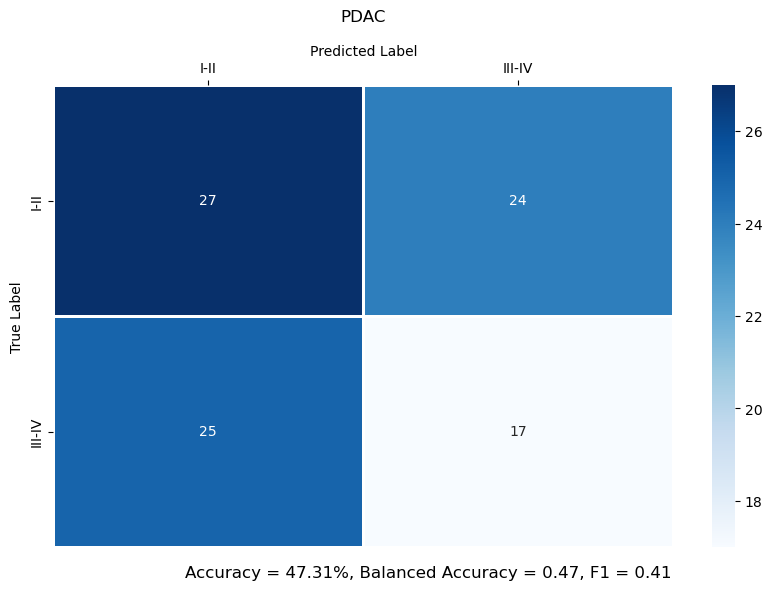

In [19]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'PDAC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, F1 = {f1:.2f}'

filename = f'baseline.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary_2, filename))

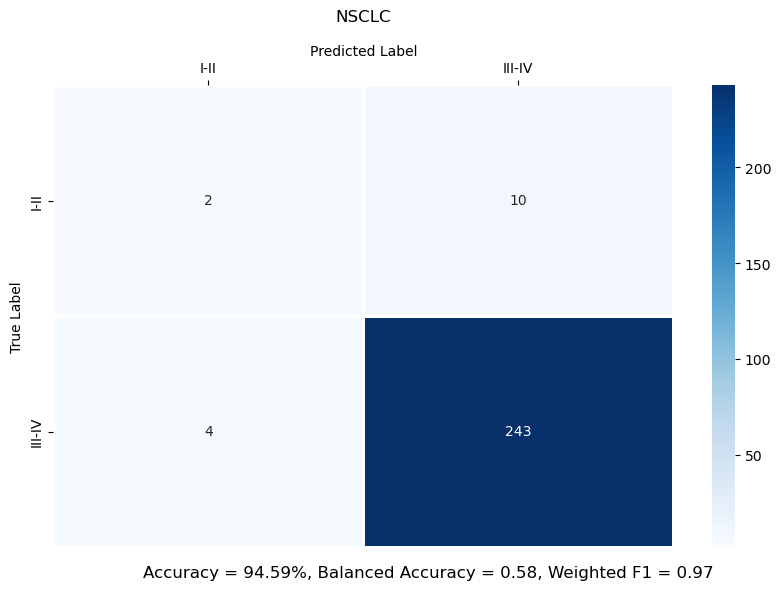

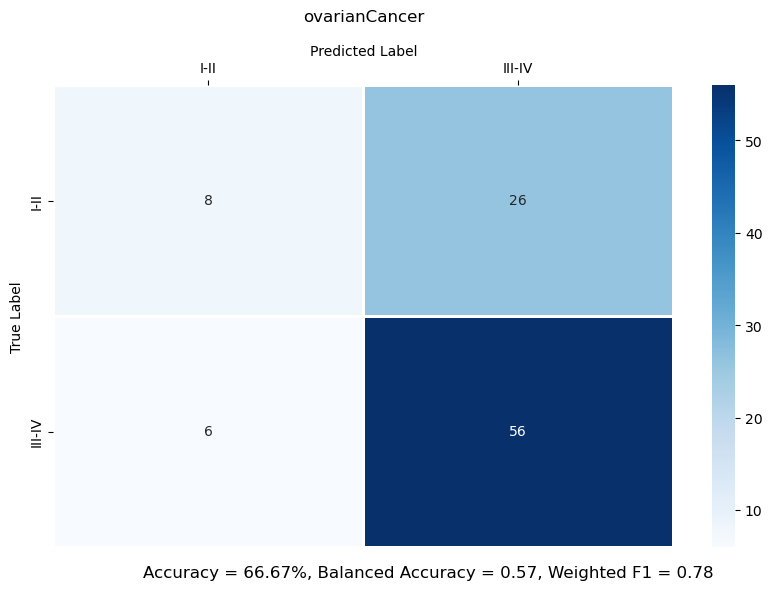

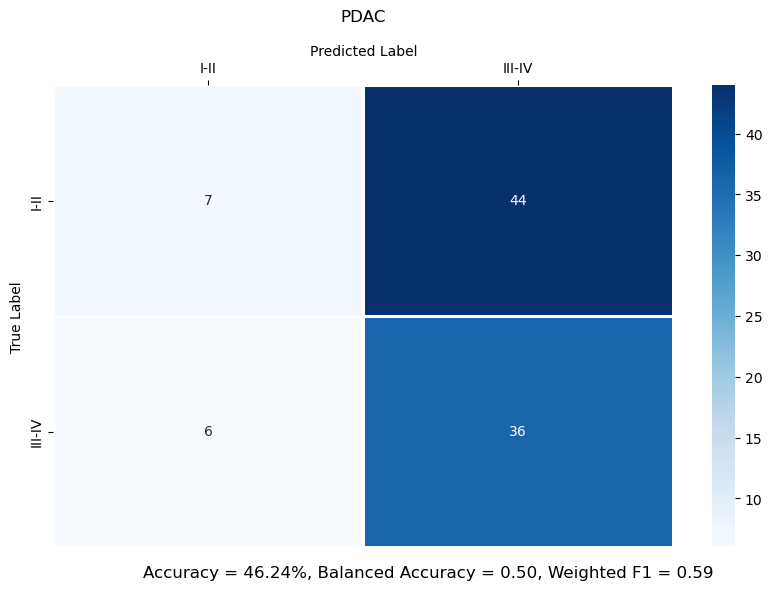

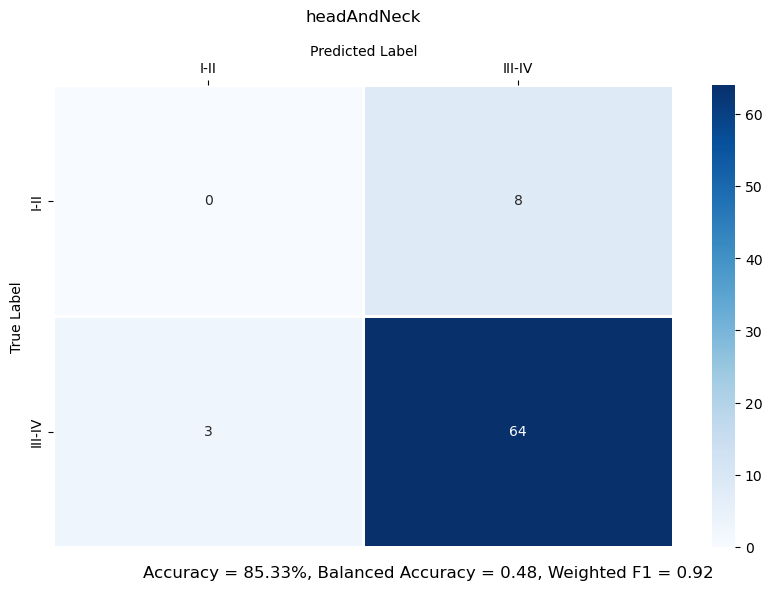

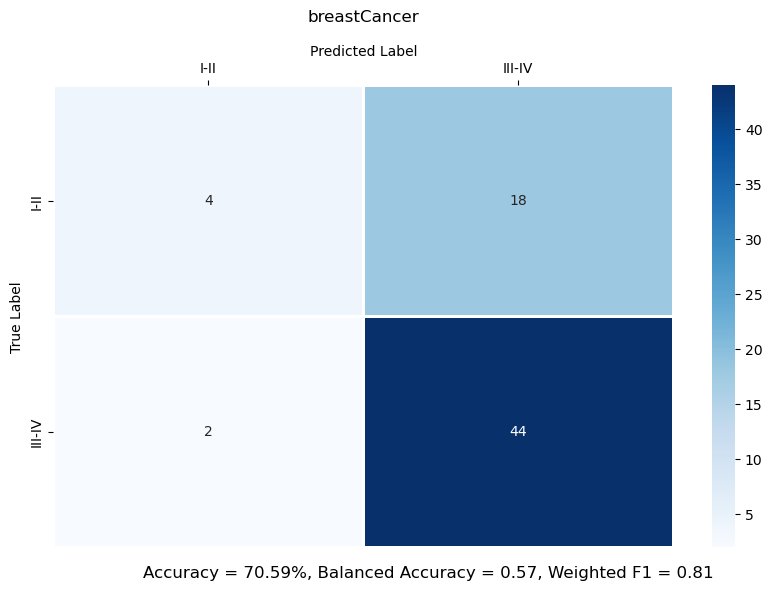

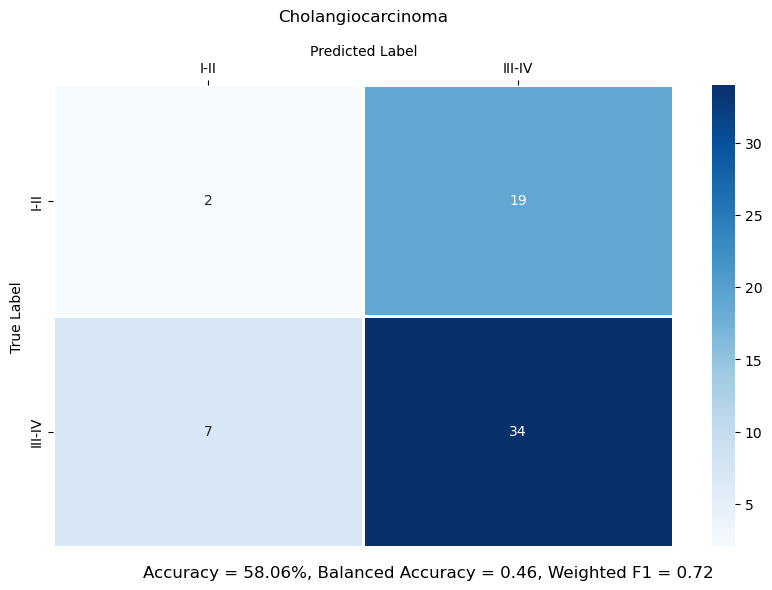

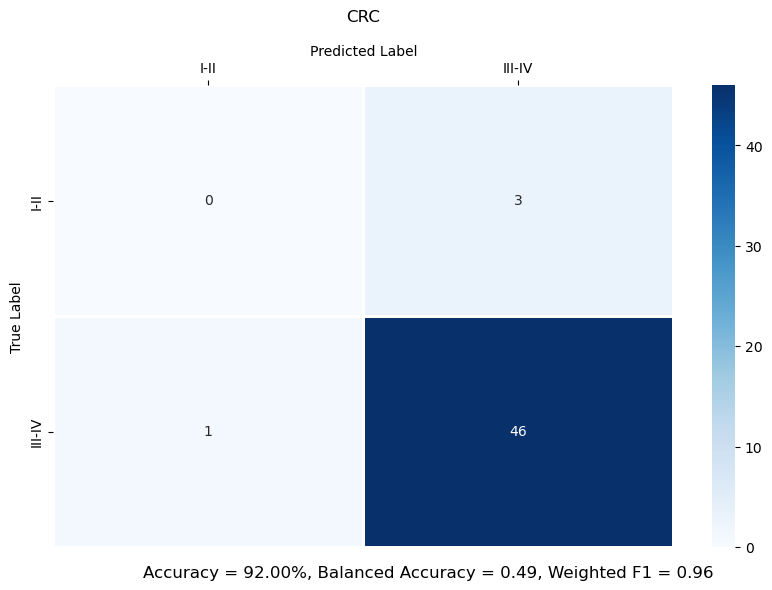

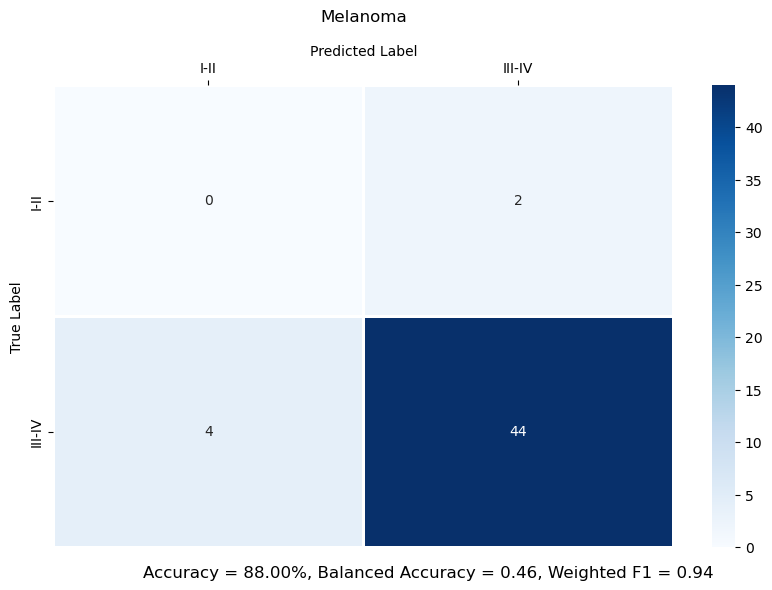

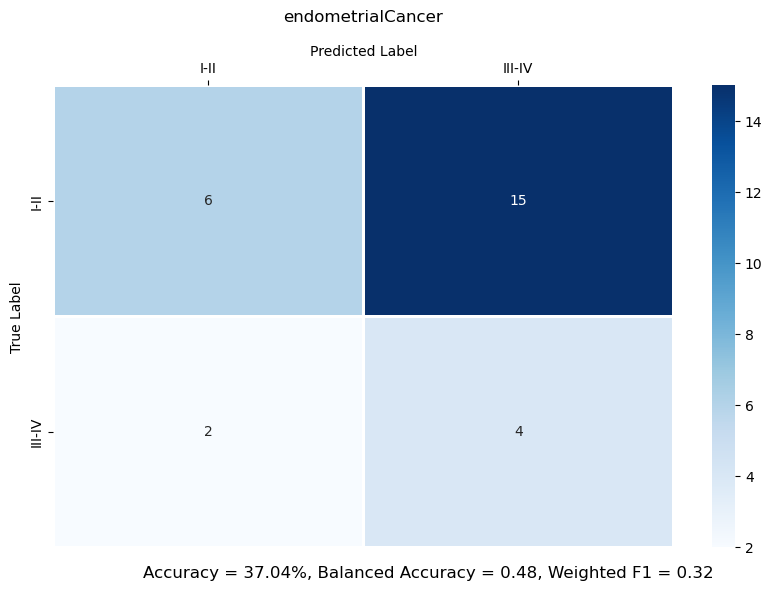

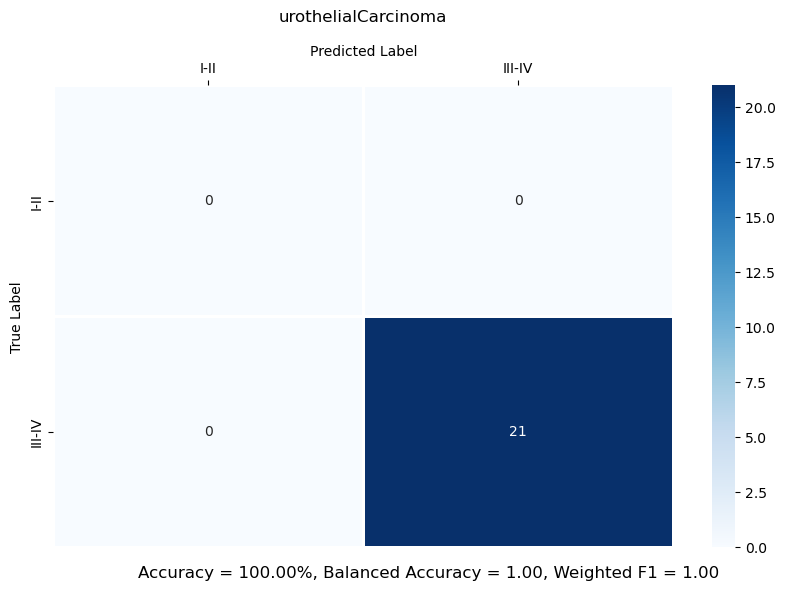

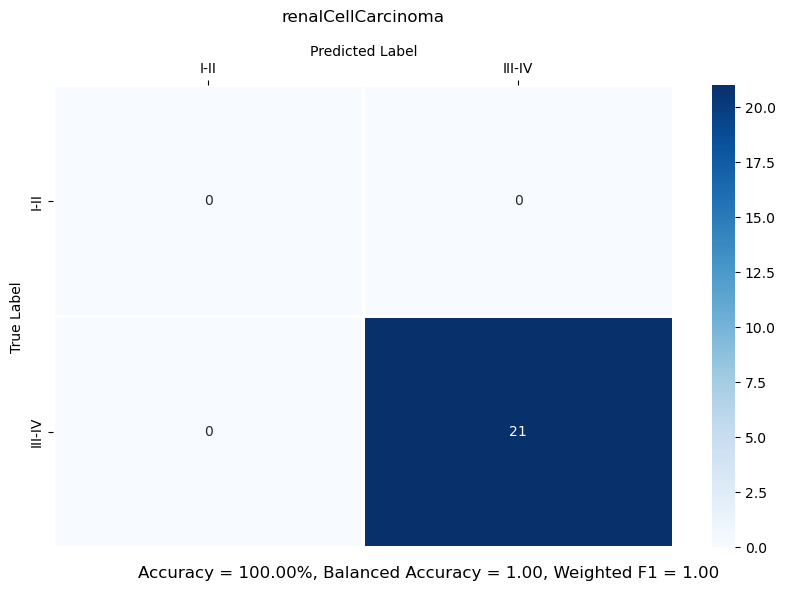

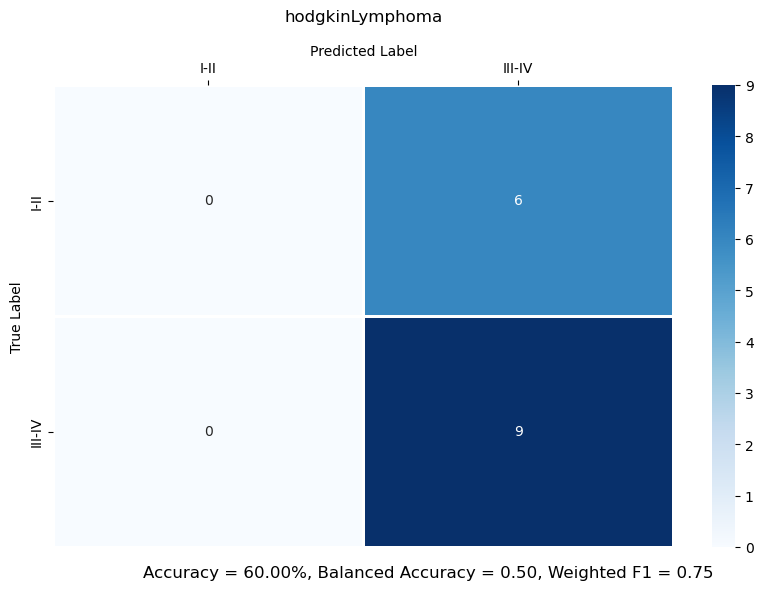

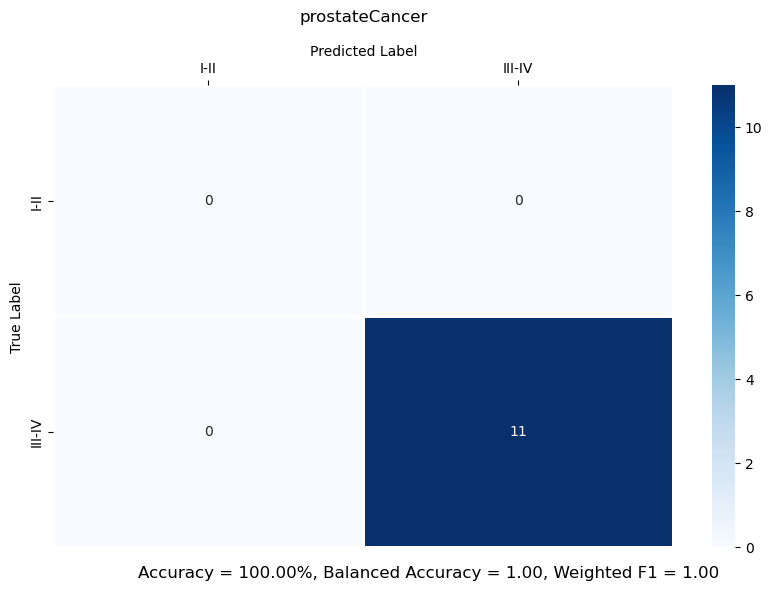

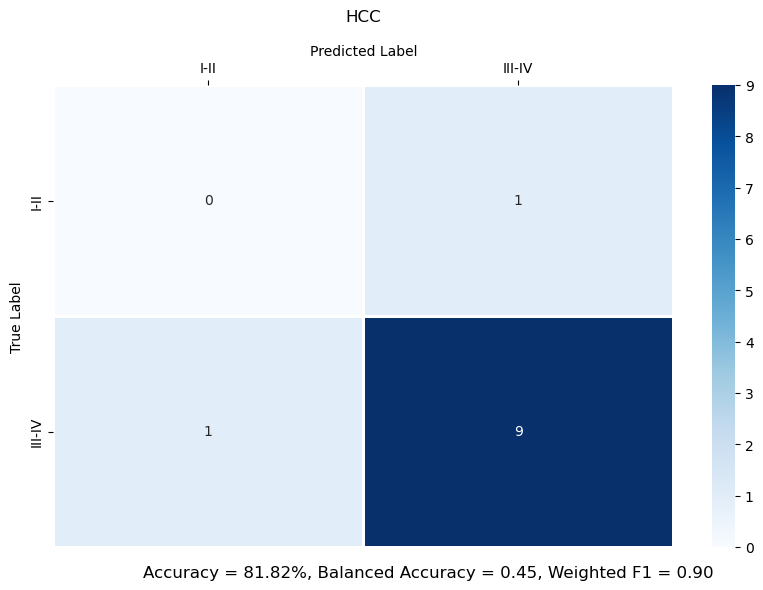

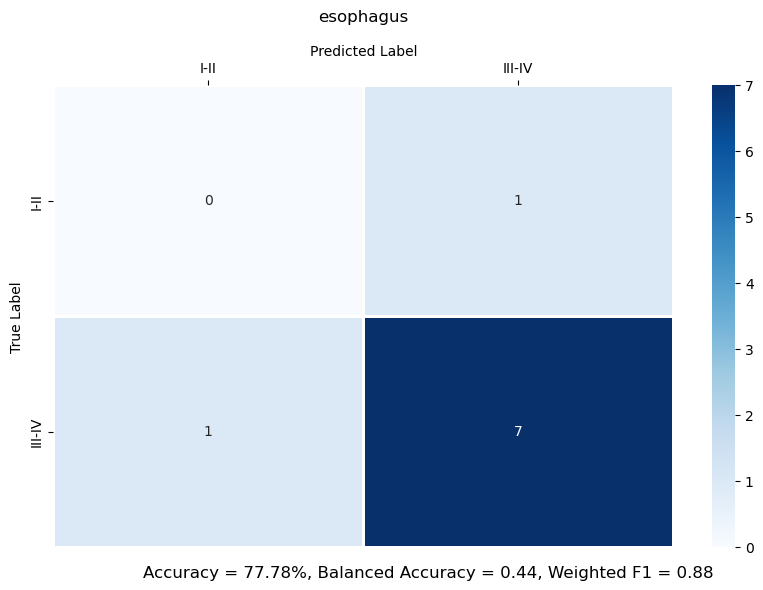

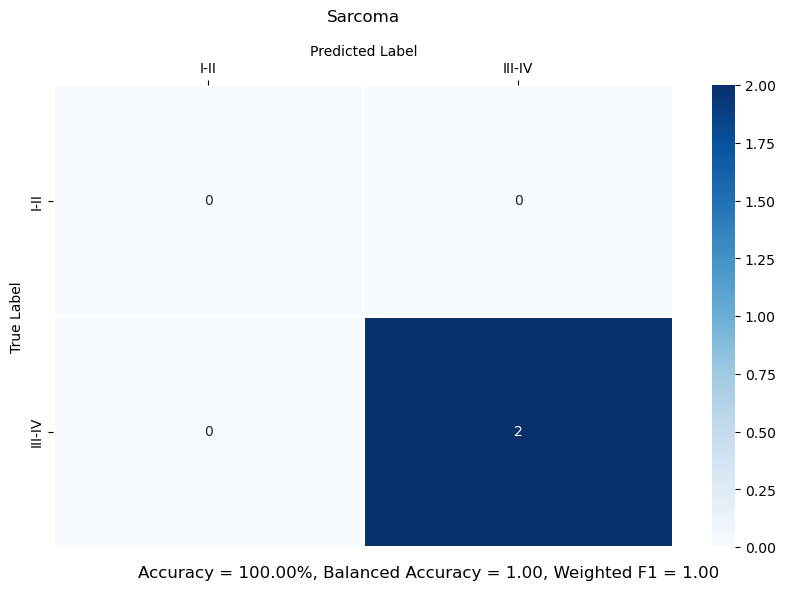

In [12]:
results = pd.DataFrame({
    'group': cancer_types,
    'y_true': y_true,
    'y_pred': y_pred.astype(int)
})

group_names = cancer_types.value_counts().index

for group_name in group_names:
    sub_results = results.loc[results['group'] == group_name]

    accuracy = accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    balanced_accuracy = balanced_accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    f1 = f1_score(sub_results['y_true'], sub_results['y_pred'])
    cm = confusion_matrix(sub_results['y_true'], sub_results['y_pred'], labels=[0, 1])

    title = group_name
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

    filename = f'all_cancer_types_only_{group_name.lower().replace(" ", "_")}_results.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary_2, filename))

## Only the most numerous types of cancer (each one separately), multiclass classification (stages: I, II, III, IV)

In [18]:
labels_encoding = {
    'I': 0,
    'II': 1,
    'III': 2,
    'IV': 3
}

xgb_config = {
    'objective': 'multi:softmax',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'num_class': 4,
}

scoring_func = balanced_accuracy_score

Get only the most numerous cancer types (with more than 90 cases)

In [19]:
cancer_type_counts = train['Group'].value_counts()
numerous_cancer_types = cancer_type_counts[cancer_type_counts > 90].index.tolist()
numerous_cancer_types

['NSCLC', 'ovarianCancer', 'PDAC']

For each cancer type a separate model will be created, optimized and tested

### NSCLC

In [20]:
X_train = train.loc[train['Group'] == 'NSCLC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

3    220
2     27
0      7
1      5
Name: Stage, dtype: int64

In [21]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 14:25:32,125] A new study created in memory with name: no-name-4635ea8c-4e47-4863-b4b6-4be0c2cd9e4d
[I 2023-10-21 14:26:00,557] Trial 0 finished with value: 0.36939935064935064 and parameters: {'n_estimators': 139, 'max_depth': 6, 'learning_rate': 0.34486593397974746, 'subsample': 0.982100937784357, 'colsample_bytree': 0.6772606557143075, 'gamma': 1.5691424150149342}. Best is trial 0 with value: 0.36939935064935064.
[I 2023-10-21 14:26:17,961] Trial 1 finished with value: 0.3403409090909091 and parameters: {'n_estimators': 84, 'max_depth': 6, 'learning_rate': 0.43032475747941423, 'subsample': 0.7896493314593368, 'colsample_bytree': 0.9183654483595054, 'gamma': 3.2384515059942287}. Best is trial 0 with value: 0.36939935064935064.
[I 2023-10-21 14:26:42,085] Trial 2 finished with value: 0.25 and parameters: {'n_estimators': 123, 'max_depth': 4, 'learning_rate': 0.06642340234176415, 'subsample': 0.6588990631857521, 'colsample_bytree': 0.6210376030993855, 'gamma': 4.358442028

[I 2023-10-21 14:34:09,864] Trial 25 finished with value: 0.3827922077922078 and parameters: {'n_estimators': 68, 'max_depth': 6, 'learning_rate': 0.051176093969442824, 'subsample': 0.9097009432207626, 'colsample_bytree': 0.7359472516494693, 'gamma': 2.419591976977379}. Best is trial 3 with value: 0.4363636363636364.
[I 2023-10-21 14:34:27,503] Trial 26 finished with value: 0.28125 and parameters: {'n_estimators': 78, 'max_depth': 4, 'learning_rate': 0.1547732614409807, 'subsample': 0.8473404598393786, 'colsample_bytree': 0.8987014352005246, 'gamma': 3.4974220638389104}. Best is trial 3 with value: 0.4363636363636364.
[I 2023-10-21 14:34:49,524] Trial 27 finished with value: 0.3515422077922078 and parameters: {'n_estimators': 92, 'max_depth': 7, 'learning_rate': 0.10244966842044892, 'subsample': 0.9673404655322261, 'colsample_bytree': 0.8243560611382819, 'gamma': 1.9714615523630727}. Best is trial 3 with value: 0.4363636363636364.
[I 2023-10-21 14:35:20,155] Trial 28 finished with valu

[I 2023-10-21 14:42:24,090] Trial 50 finished with value: 0.3515422077922078 and parameters: {'n_estimators': 72, 'max_depth': 8, 'learning_rate': 0.10553922376548376, 'subsample': 0.9312863272891931, 'colsample_bytree': 0.9997875858384211, 'gamma': 2.5551663480218054}. Best is trial 41 with value: 0.4407467532467532.
[I 2023-10-21 14:42:42,398] Trial 51 finished with value: 0.4363636363636364 and parameters: {'n_estimators': 55, 'max_depth': 7, 'learning_rate': 0.00464472110609887, 'subsample': 0.982986326853628, 'colsample_bytree': 0.7038406456986048, 'gamma': 2.8545228886395404}. Best is trial 41 with value: 0.4407467532467532.
[I 2023-10-21 14:43:00,602] Trial 52 finished with value: 0.4363636363636364 and parameters: {'n_estimators': 60, 'max_depth': 7, 'learning_rate': 0.027214758177947832, 'subsample': 0.9542943061396, 'colsample_bytree': 0.7673867825111801, 'gamma': 2.706513554379252}. Best is trial 41 with value: 0.4407467532467532.
[I 2023-10-21 14:43:19,002] Trial 53 finishe

[I 2023-10-21 14:50:29,913] Trial 75 finished with value: 0.4363636363636364 and parameters: {'n_estimators': 38, 'max_depth': 7, 'learning_rate': 0.029430594901951594, 'subsample': 0.9858106786947525, 'colsample_bytree': 0.739076513871462, 'gamma': 2.0801842705642173}. Best is trial 53 with value: 0.4452922077922078.
[I 2023-10-21 14:50:44,087] Trial 76 finished with value: 0.4340909090909091 and parameters: {'n_estimators': 31, 'max_depth': 5, 'learning_rate': 0.0014245313804155313, 'subsample': 0.9694533290677944, 'colsample_bytree': 0.9296553351425993, 'gamma': 2.4467011116392867}. Best is trial 53 with value: 0.4452922077922078.
[I 2023-10-21 14:51:18,452] Trial 77 finished with value: 0.3426136363636364 and parameters: {'n_estimators': 134, 'max_depth': 8, 'learning_rate': 0.07420681137595081, 'subsample': 0.9339570601085643, 'colsample_bytree': 0.910594112389633, 'gamma': 1.8148503600918726}. Best is trial 53 with value: 0.4452922077922078.
[I 2023-10-21 14:51:44,322] Trial 78 f

In [22]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.62      0.71      0.67         7
          II       0.00      0.00      0.00         5
         III       1.00      0.04      0.07        27
          IV       0.88      1.00      0.93       220

    accuracy                           0.87       259
   macro avg       0.63      0.44      0.42       259
weighted avg       0.87      0.87      0.82       259



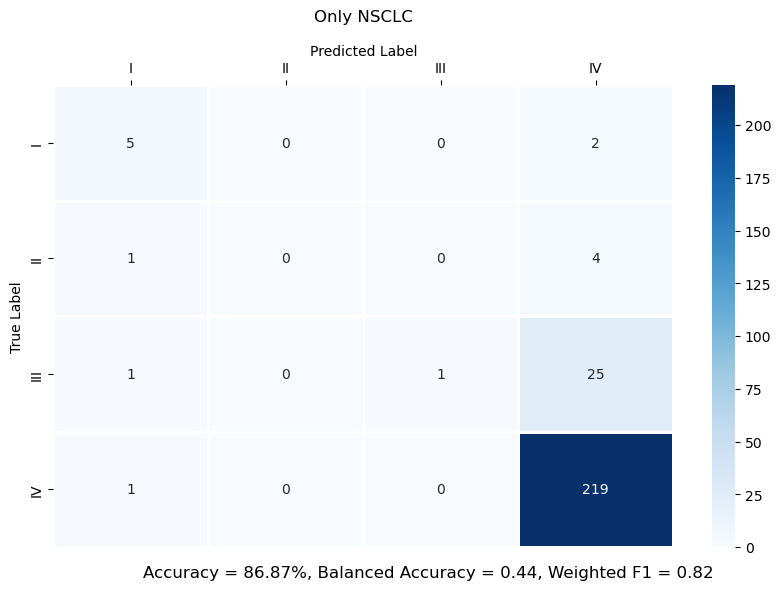

In [23]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only NSCLC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'nsclc_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

### Ovarian cancer

In [24]:
X_train = train.loc[train['Group'] == 'ovarianCancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

2    36
3    26
0    22
1    12
Name: Stage, dtype: int64

In [25]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 14:59:07,928] A new study created in memory with name: no-name-e3c44114-d4ac-432d-a3d0-8e6263245e82
[I 2023-10-21 14:59:26,579] Trial 0 finished with value: 0.4636904761904762 and parameters: {'n_estimators': 119, 'max_depth': 3, 'learning_rate': 0.27716393247456483, 'subsample': 0.9076638540526689, 'colsample_bytree': 0.8476208667975739, 'gamma': 1.481041482628949}. Best is trial 0 with value: 0.4636904761904762.
[I 2023-10-21 14:59:42,456] Trial 1 finished with value: 0.4518849206349206 and parameters: {'n_estimators': 105, 'max_depth': 4, 'learning_rate': 0.33535351310209116, 'subsample': 0.7960504230057397, 'colsample_bytree': 0.7649419201322958, 'gamma': 4.44593694824983}. Best is trial 0 with value: 0.4636904761904762.
[I 2023-10-21 14:59:51,509] Trial 2 finished with value: 0.45674603174603173 and parameters: {'n_estimators': 37, 'max_depth': 2, 'learning_rate': 0.2598904709837388, 'subsample': 0.5448563355418272, 'colsample_bytree': 0.7696972694686055, 'gamma': 0.

[I 2023-10-21 15:05:02,383] Trial 25 finished with value: 0.45049603174603176 and parameters: {'n_estimators': 69, 'max_depth': 3, 'learning_rate': 0.30832936582365017, 'subsample': 0.8277071571137634, 'colsample_bytree': 0.7120143283884454, 'gamma': 3.7954606163366784}. Best is trial 0 with value: 0.4636904761904762.
[I 2023-10-21 15:05:22,000] Trial 26 finished with value: 0.42549603174603173 and parameters: {'n_estimators': 149, 'max_depth': 5, 'learning_rate': 0.2607829046771383, 'subsample': 0.7091316261243161, 'colsample_bytree': 0.766490809131567, 'gamma': 1.2810141329183624}. Best is trial 0 with value: 0.4636904761904762.
[I 2023-10-21 15:05:39,413] Trial 27 finished with value: 0.42559523809523814 and parameters: {'n_estimators': 129, 'max_depth': 7, 'learning_rate': 0.36972715818119595, 'subsample': 0.9140271780920685, 'colsample_bytree': 0.808596095517613, 'gamma': 2.273422389827524}. Best is trial 0 with value: 0.4636904761904762.
[I 2023-10-21 15:05:54,260] Trial 28 finis

[I 2023-10-21 15:10:25,243] Trial 50 finished with value: 0.4268849206349206 and parameters: {'n_estimators': 38, 'max_depth': 7, 'learning_rate': 0.12771211400909205, 'subsample': 0.8678901033045073, 'colsample_bytree': 0.5047027149022576, 'gamma': 0.7291411495613611}. Best is trial 42 with value: 0.5039682539682541.
[I 2023-10-21 15:10:37,631] Trial 51 finished with value: 0.47619047619047616 and parameters: {'n_estimators': 63, 'max_depth': 5, 'learning_rate': 0.2096775022765681, 'subsample': 0.8100001669503643, 'colsample_bytree': 0.617600337297057, 'gamma': 0.4942513737602695}. Best is trial 42 with value: 0.5039682539682541.
[I 2023-10-21 15:10:48,955] Trial 52 finished with value: 0.48313492063492064 and parameters: {'n_estimators': 55, 'max_depth': 6, 'learning_rate': 0.2056033258390596, 'subsample': 0.8437968326403847, 'colsample_bytree': 0.6113116826875048, 'gamma': 0.6156989528194907}. Best is trial 42 with value: 0.5039682539682541.
[I 2023-10-21 15:11:02,231] Trial 53 fini

[I 2023-10-21 15:14:51,640] Trial 75 finished with value: 0.44285714285714284 and parameters: {'n_estimators': 55, 'max_depth': 3, 'learning_rate': 0.15397014847461044, 'subsample': 0.7497012333537384, 'colsample_bytree': 0.5909157527427367, 'gamma': 0.31536164774182124}. Best is trial 42 with value: 0.5039682539682541.
[I 2023-10-21 15:15:00,641] Trial 76 finished with value: 0.428968253968254 and parameters: {'n_estimators': 48, 'max_depth': 2, 'learning_rate': 0.11362753470595668, 'subsample': 0.7762048334969383, 'colsample_bytree': 0.6247930313812892, 'gamma': 0.08201191770709759}. Best is trial 42 with value: 0.5039682539682541.
[I 2023-10-21 15:15:08,547] Trial 77 finished with value: 0.4935515873015873 and parameters: {'n_estimators': 27, 'max_depth': 4, 'learning_rate': 0.07200654159459613, 'subsample': 0.7989782738685356, 'colsample_bytree': 0.6340401183724311, 'gamma': 0.6178813393001762}. Best is trial 42 with value: 0.5039682539682541.
[I 2023-10-21 15:15:15,939] Trial 78 f

In [26]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.41      0.41      0.41        22
          II       0.00      0.00      0.00        12
         III       0.49      0.67      0.56        36
          IV       0.83      0.77      0.80        26

    accuracy                           0.55        96
   macro avg       0.43      0.46      0.44        96
weighted avg       0.50      0.55      0.52        96



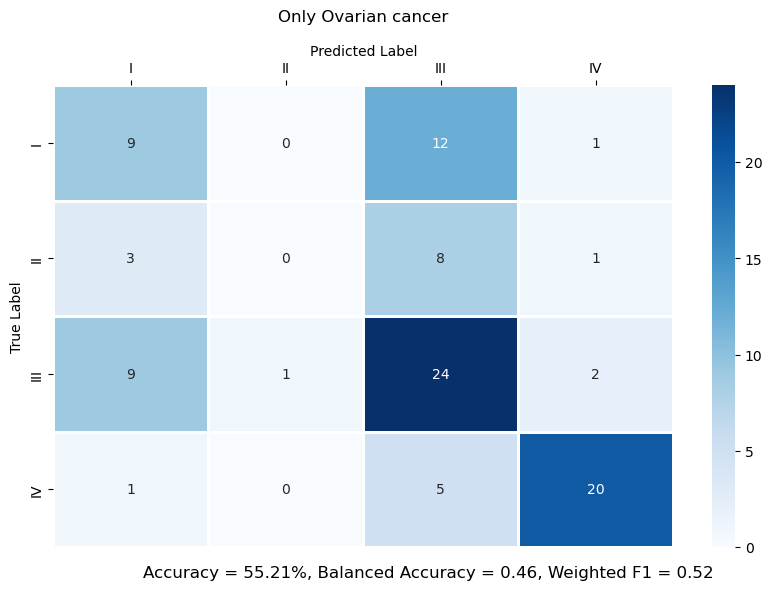

In [27]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only Ovarian cancer'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'ovarian_cancer_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

### PDAC


In [28]:
X_train = train.loc[train['Group'] == 'PDAC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

1    49
2    23
3    19
0     2
Name: Stage, dtype: int64

In [29]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 15:18:28,599] A new study created in memory with name: no-name-9453ef72-ba68-4128-89b8-2ff92c9c436a
[I 2023-10-21 15:18:48,255] Trial 0 finished with value: 0.27857905982905984 and parameters: {'n_estimators': 136, 'max_depth': 7, 'learning_rate': 0.20526278413861374, 'subsample': 0.6138813186110139, 'colsample_bytree': 0.6082656452771443, 'gamma': 4.919884910128474}. Best is trial 0 with value: 0.27857905982905984.
[I 2023-10-21 15:19:16,700] Trial 1 finished with value: 0.2789797008547008 and parameters: {'n_estimators': 140, 'max_depth': 4, 'learning_rate': 0.05602023110092245, 'subsample': 0.7263631159840773, 'colsample_bytree': 0.8528051765077372, 'gamma': 0.08691063516708175}. Best is trial 1 with value: 0.2789797008547008.
[I 2023-10-21 15:19:37,897] Trial 2 finished with value: 0.2687232905982906 and parameters: {'n_estimators': 137, 'max_depth': 5, 'learning_rate': 0.42382213933271623, 'subsample': 0.9854781695040913, 'colsample_bytree': 0.9894610353687363, 'gamm

[I 2023-10-21 15:25:41,955] Trial 25 finished with value: 0.31971153846153844 and parameters: {'n_estimators': 113, 'max_depth': 6, 'learning_rate': 0.4885860500437962, 'subsample': 0.5618393579033132, 'colsample_bytree': 0.6008708181122571, 'gamma': 1.012262660712923}. Best is trial 25 with value: 0.31971153846153844.
[I 2023-10-21 15:25:55,485] Trial 26 finished with value: 0.3473290598290598 and parameters: {'n_estimators': 94, 'max_depth': 7, 'learning_rate': 0.40932386715171926, 'subsample': 0.5916519408040204, 'colsample_bytree': 0.5865120254706098, 'gamma': 0.9746896833807596}. Best is trial 26 with value: 0.3473290598290598.
[I 2023-10-21 15:26:08,723] Trial 27 finished with value: 0.2779380341880342 and parameters: {'n_estimators': 89, 'max_depth': 7, 'learning_rate': 0.4140532921347157, 'subsample': 0.6458240002429674, 'colsample_bytree': 0.6551547990302227, 'gamma': 0.9453358249228255}. Best is trial 26 with value: 0.3473290598290598.
[I 2023-10-21 15:26:20,709] Trial 28 fin

[I 2023-10-21 15:31:31,824] Trial 50 finished with value: 0.3228899572649573 and parameters: {'n_estimators': 129, 'max_depth': 8, 'learning_rate': 0.34564568485560954, 'subsample': 0.5260632620397632, 'colsample_bytree': 0.5765181011080939, 'gamma': 0.1838625513980745}. Best is trial 48 with value: 0.34922542735042733.
[I 2023-10-21 15:31:45,791] Trial 51 finished with value: 0.2950587606837607 and parameters: {'n_estimators': 133, 'max_depth': 8, 'learning_rate': 0.3445898785615589, 'subsample': 0.500045629134298, 'colsample_bytree': 0.5739539421463912, 'gamma': 0.215399259896222}. Best is trial 48 with value: 0.34922542735042733.
[I 2023-10-21 15:32:00,390] Trial 52 finished with value: 0.3016559829059829 and parameters: {'n_estimators': 138, 'max_depth': 8, 'learning_rate': 0.3971155109381118, 'subsample': 0.5244329758529527, 'colsample_bytree': 0.5532712048947195, 'gamma': 0.4511124717775671}. Best is trial 48 with value: 0.34922542735042733.
[I 2023-10-21 15:32:14,149] Trial 53 f

[I 2023-10-21 15:37:10,533] Trial 75 finished with value: 0.2624198717948718 and parameters: {'n_estimators': 123, 'max_depth': 2, 'learning_rate': 0.48368939104327263, 'subsample': 0.5404185689335861, 'colsample_bytree': 0.5629785735849463, 'gamma': 1.1326974547000226}. Best is trial 67 with value: 0.3786324786324786.
[I 2023-10-21 15:37:25,676] Trial 76 finished with value: 0.32574786324786326 and parameters: {'n_estimators': 147, 'max_depth': 7, 'learning_rate': 0.4615541294225559, 'subsample': 0.5125067427049385, 'colsample_bytree': 0.6157304834542475, 'gamma': 0.49110605898271376}. Best is trial 67 with value: 0.3786324786324786.
[I 2023-10-21 15:37:40,059] Trial 77 finished with value: 0.3064636752136752 and parameters: {'n_estimators': 141, 'max_depth': 3, 'learning_rate': 0.4033611410319803, 'subsample': 0.5885907923499187, 'colsample_bytree': 0.5428545066310184, 'gamma': 0.7608367261076838}. Best is trial 67 with value: 0.3786324786324786.
[I 2023-10-21 15:37:46,156] Trial 78 

In [30]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.00      0.00      0.00         2
          II       0.60      0.82      0.69        49
         III       0.28      0.22      0.24        23
          IV       0.12      0.05      0.07        19

    accuracy                           0.49        93
   macro avg       0.25      0.27      0.25        93
weighted avg       0.41      0.49      0.44        93



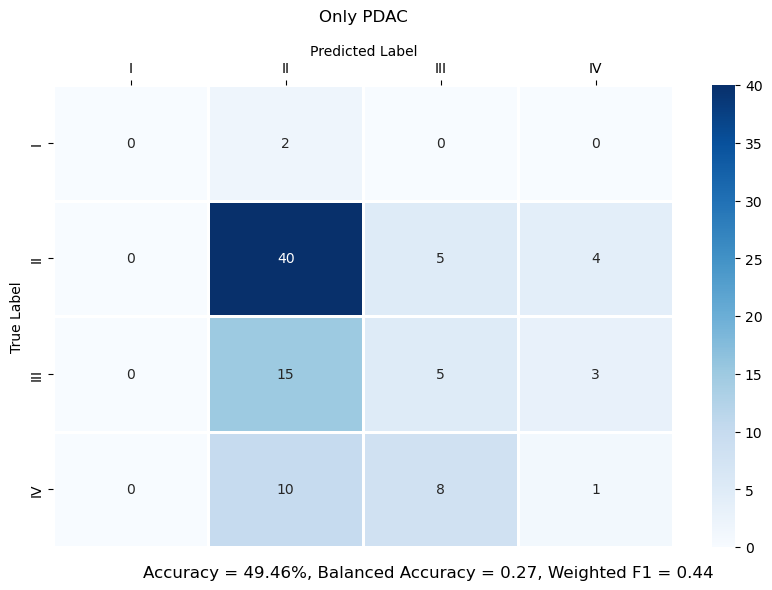

In [31]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only PDAC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'pdac_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

## Only the most numerous types of cancer (each one separately), binary classification (stages: I-III vs IV)

In [32]:
mapping = {
    'I': 'I-III',
    'II': 'I-III',
    'III': 'I-III',
    'IV': 'IV'
}

labels_encoding = {
    'I-III': 0,
    'IV': 1
}

xgb_config = {
    'objective': 'binary:logistic',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0
}

### NSCLC

In [33]:
X_train = train.loc[train['Group'] == 'NSCLC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

1    220
0     39
Name: Stage, dtype: int64

In [34]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 15:42:53,999] A new study created in memory with name: no-name-12d01f4f-40b2-495f-b2c9-5e068d119199
[I 2023-10-21 15:43:03,765] Trial 0 finished with value: 0.6589646464646464 and parameters: {'n_estimators': 84, 'max_depth': 8, 'learning_rate': 0.20985165942253473, 'subsample': 0.8253724865316201, 'colsample_bytree': 0.5879898608449359, 'gamma': 2.7469359781466443}. Best is trial 0 with value: 0.6589646464646464.
[I 2023-10-21 15:43:09,556] Trial 1 finished with value: 0.6373737373737374 and parameters: {'n_estimators': 27, 'max_depth': 6, 'learning_rate': 0.46202204592224677, 'subsample': 0.5691382698914453, 'colsample_bytree': 0.8663601982987225, 'gamma': 3.1183579839041253}. Best is trial 0 with value: 0.6589646464646464.
[I 2023-10-21 15:43:21,647] Trial 2 finished with value: 0.6751262626262626 and parameters: {'n_estimators': 134, 'max_depth': 3, 'learning_rate': 0.2704958927151972, 'subsample': 0.9110601630714519, 'colsample_bytree': 0.8300600005086531, 'gamma': 4

[I 2023-10-21 15:47:04,244] Trial 25 finished with value: 0.6765151515151515 and parameters: {'n_estimators': 53, 'max_depth': 5, 'learning_rate': 0.12086516939344925, 'subsample': 0.9156112370080467, 'colsample_bytree': 0.9546335769024512, 'gamma': 1.2233396717631813}. Best is trial 10 with value: 0.7117424242424243.
[I 2023-10-21 15:47:15,643] Trial 26 finished with value: 0.7001262626262627 and parameters: {'n_estimators': 73, 'max_depth': 4, 'learning_rate': 0.03807595501070738, 'subsample': 0.8543652351852995, 'colsample_bytree': 0.9009401298659075, 'gamma': 0.36148937992798125}. Best is trial 10 with value: 0.7117424242424243.
[I 2023-10-21 15:47:25,402] Trial 27 finished with value: 0.7265151515151516 and parameters: {'n_estimators': 58, 'max_depth': 6, 'learning_rate': 0.08650138248108852, 'subsample': 0.9605280942245038, 'colsample_bytree': 0.9607949815866148, 'gamma': 0.9105423333778337}. Best is trial 27 with value: 0.7265151515151516.
[I 2023-10-21 15:47:32,759] Trial 28 fi

[I 2023-10-21 15:50:43,713] Trial 50 finished with value: 0.7162878787878788 and parameters: {'n_estimators': 34, 'max_depth': 5, 'learning_rate': 0.08050530796935534, 'subsample': 0.9391998078240699, 'colsample_bytree': 0.9775402135009168, 'gamma': 1.2541792603057846}. Best is trial 27 with value: 0.7265151515151516.
[I 2023-10-21 15:50:50,553] Trial 51 finished with value: 0.6946969696969697 and parameters: {'n_estimators': 26, 'max_depth': 5, 'learning_rate': 0.07609321050781899, 'subsample': 0.9441775244976935, 'colsample_bytree': 0.9757474458760497, 'gamma': 1.2524455284631686}. Best is trial 27 with value: 0.7265151515151516.
[I 2023-10-21 15:50:57,876] Trial 52 finished with value: 0.7097222222222223 and parameters: {'n_estimators': 32, 'max_depth': 4, 'learning_rate': 0.004003432641186952, 'subsample': 0.9757078669653859, 'colsample_bytree': 0.948622649780631, 'gamma': 0.8477155157635424}. Best is trial 27 with value: 0.7265151515151516.
[I 2023-10-21 15:51:05,829] Trial 53 fin

[I 2023-10-21 15:54:01,666] Trial 75 finished with value: 0.709469696969697 and parameters: {'n_estimators': 52, 'max_depth': 6, 'learning_rate': 0.03839727937634159, 'subsample': 0.9816519599604154, 'colsample_bytree': 0.9477663093720221, 'gamma': 1.3872446530236702}. Best is trial 59 with value: 0.7287878787878788.
[I 2023-10-21 15:54:08,782] Trial 76 finished with value: 0.6751262626262626 and parameters: {'n_estimators': 32, 'max_depth': 7, 'learning_rate': 0.12439994478156796, 'subsample': 0.9299659799420871, 'colsample_bytree': 0.8586899875814746, 'gamma': 1.1328678941025265}. Best is trial 59 with value: 0.7287878787878788.
[I 2023-10-21 15:54:23,709] Trial 77 finished with value: 0.7037878787878787 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.10642676266735515, 'subsample': 0.9534652212687165, 'colsample_bytree': 0.9654635068183136, 'gamma': 1.5722040732931906}. Best is trial 59 with value: 0.7287878787878788.
[I 2023-10-21 15:54:39,324] Trial 78 fin

In [35]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.68      0.33      0.45        39
          IV       0.89      0.97      0.93       220

    accuracy                           0.88       259
   macro avg       0.79      0.65      0.69       259
weighted avg       0.86      0.88      0.86       259



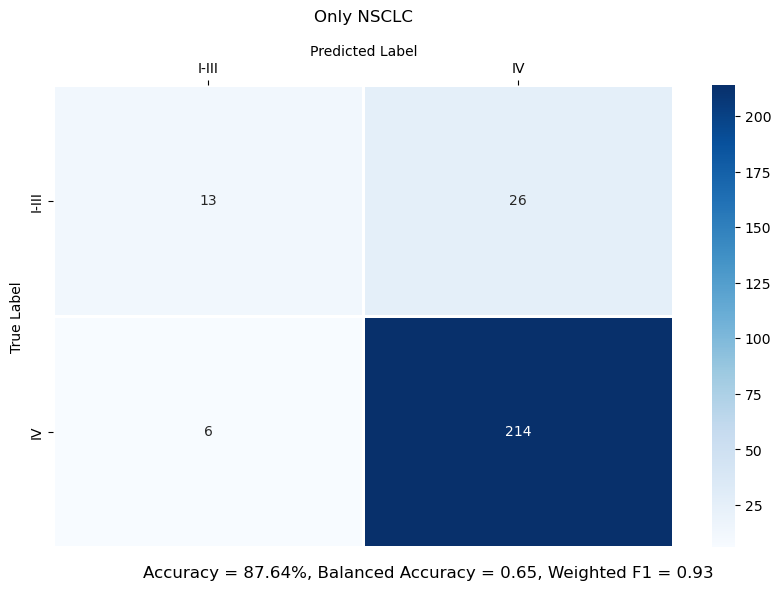

In [36]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only NSCLC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'nsclc_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

### Ovarian cancer

In [37]:
X_train = train.loc[train['Group'] == 'ovarianCancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

0    70
1    26
Name: Stage, dtype: int64

In [38]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 15:57:49,803] A new study created in memory with name: no-name-53e0729a-9b0d-4a25-8172-5c55ed97a5a5
[I 2023-10-21 15:57:59,667] Trial 0 finished with value: 0.8299486461251168 and parameters: {'n_estimators': 90, 'max_depth': 3, 'learning_rate': 0.4239721148531227, 'subsample': 0.8154476474739218, 'colsample_bytree': 0.848328474605017, 'gamma': 4.015575937373126}. Best is trial 0 with value: 0.8299486461251168.
[I 2023-10-21 15:58:14,807] Trial 1 finished with value: 0.8473972922502334 and parameters: {'n_estimators': 149, 'max_depth': 4, 'learning_rate': 0.2369201307086532, 'subsample': 0.7585937878015556, 'colsample_bytree': 0.9152444767301033, 'gamma': 1.9163584318690225}. Best is trial 1 with value: 0.8473972922502334.
[I 2023-10-21 15:58:21,484] Trial 2 finished with value: 0.7987861811391224 and parameters: {'n_estimators': 41, 'max_depth': 6, 'learning_rate': 0.3276801484615678, 'subsample': 0.9650323970754572, 'colsample_bytree': 0.6447550902664891, 'gamma': 1.273

[I 2023-10-21 16:01:48,493] Trial 25 finished with value: 0.8751750700280112 and parameters: {'n_estimators': 55, 'max_depth': 5, 'learning_rate': 0.0019943406930373747, 'subsample': 0.8802567512825817, 'colsample_bytree': 0.563449506678962, 'gamma': 1.837976114450752}. Best is trial 8 with value: 0.8755835667600373.
[I 2023-10-21 16:01:57,108] Trial 26 finished with value: 0.8755835667600373 and parameters: {'n_estimators': 70, 'max_depth': 7, 'learning_rate': 0.11395066231367226, 'subsample': 0.9591133758554162, 'colsample_bytree': 0.6239839255210112, 'gamma': 3.3714807875011106}. Best is trial 8 with value: 0.8755835667600373.
[I 2023-10-21 16:02:04,262] Trial 27 finished with value: 0.854750233426704 and parameters: {'n_estimators': 48, 'max_depth': 6, 'learning_rate': 0.16028215271222396, 'subsample': 0.8110139388440303, 'colsample_bytree': 0.5202678123773852, 'gamma': 2.5682920239777696}. Best is trial 8 with value: 0.8755835667600373.
[I 2023-10-21 16:02:10,345] Trial 28 finishe

[I 2023-10-21 16:04:54,056] Trial 50 finished with value: 0.8686391223155929 and parameters: {'n_estimators': 61, 'max_depth': 8, 'learning_rate': 0.14304194902632272, 'subsample': 0.9975254679992954, 'colsample_bytree': 0.6419821923804738, 'gamma': 1.7859289326781966}. Best is trial 33 with value: 0.8825280112044818.
[I 2023-10-21 16:05:00,242] Trial 51 finished with value: 0.8686391223155929 and parameters: {'n_estimators': 25, 'max_depth': 8, 'learning_rate': 0.101108517065732, 'subsample': 0.9546896475303136, 'colsample_bytree': 0.650723838241349, 'gamma': 2.1091033870284774}. Best is trial 33 with value: 0.8825280112044818.
[I 2023-10-21 16:05:05,862] Trial 52 finished with value: 0.8682306255835668 and parameters: {'n_estimators': 20, 'max_depth': 8, 'learning_rate': 0.08390261315950644, 'subsample': 0.9232428396653709, 'colsample_bytree': 0.6163648228479425, 'gamma': 2.6800365240242723}. Best is trial 33 with value: 0.8825280112044818.
[I 2023-10-21 16:05:12,257] Trial 53 finish

[I 2023-10-21 16:08:03,252] Trial 75 finished with value: 0.8547502334267039 and parameters: {'n_estimators': 23, 'max_depth': 7, 'learning_rate': 0.126115648934376, 'subsample': 0.9882534638223806, 'colsample_bytree': 0.5891924903631004, 'gamma': 3.3680327260169003}. Best is trial 33 with value: 0.8825280112044818.
[I 2023-10-21 16:08:10,287] Trial 76 finished with value: 0.8612861811391224 and parameters: {'n_estimators': 39, 'max_depth': 6, 'learning_rate': 0.05625454987381089, 'subsample': 0.9413336840146145, 'colsample_bytree': 0.628928929065047, 'gamma': 3.041560078612684}. Best is trial 33 with value: 0.8825280112044818.
[I 2023-10-21 16:08:15,909] Trial 77 finished with value: 0.8126750700280112 and parameters: {'n_estimators': 27, 'max_depth': 5, 'learning_rate': 0.15697955669192504, 'subsample': 0.9787665288043546, 'colsample_bytree': 0.6688418431460276, 'gamma': 2.816960803184712}. Best is trial 33 with value: 0.8825280112044818.
[I 2023-10-21 16:08:25,151] Trial 78 finished

In [39]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.92      0.96      0.94        70
          IV       0.87      0.77      0.82        26

    accuracy                           0.91        96
   macro avg       0.89      0.86      0.88        96
weighted avg       0.90      0.91      0.90        96



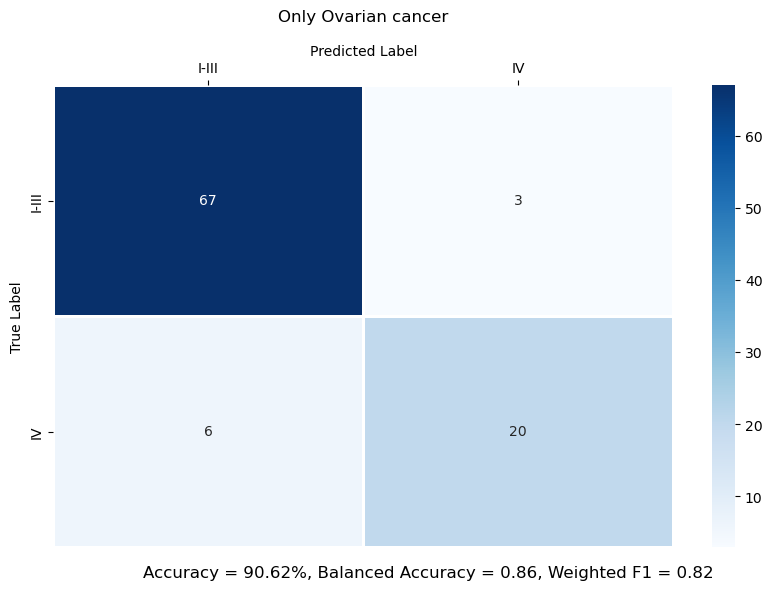

In [40]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only Ovarian cancer'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'ovarian_cancer_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

### PDAC

In [41]:
X_train = train.loc[train['Group'] == 'PDAC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

0    74
1    19
Name: Stage, dtype: int64

In [42]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-21 16:10:58,569] A new study created in memory with name: no-name-bd89b428-27f1-45ee-b073-0b547da09fe4
[I 2023-10-21 16:11:07,305] Trial 0 finished with value: 0.48611111111111116 and parameters: {'n_estimators': 59, 'max_depth': 2, 'learning_rate': 0.03507378282911271, 'subsample': 0.6242116853118344, 'colsample_bytree': 0.7767688422256247, 'gamma': 2.9832856008016977}. Best is trial 0 with value: 0.48611111111111116.
[I 2023-10-21 16:11:15,358] Trial 1 finished with value: 0.48680555555555555 and parameters: {'n_estimators': 52, 'max_depth': 8, 'learning_rate': 0.197494101555915, 'subsample': 0.6849375245003657, 'colsample_bytree': 0.6279778151228521, 'gamma': 1.150713590481363}. Best is trial 1 with value: 0.48680555555555555.
[I 2023-10-21 16:11:23,339] Trial 2 finished with value: 0.4597222222222222 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.4712654000879324, 'subsample': 0.6430265411160125, 'colsample_bytree': 0.8105152672261409, 'gamma': 0

[I 2023-10-21 16:15:17,011] Trial 25 finished with value: 0.55 and parameters: {'n_estimators': 43, 'max_depth': 6, 'learning_rate': 0.2928706270420179, 'subsample': 0.9558430617095519, 'colsample_bytree': 0.5870222202694583, 'gamma': 4.2580055625686954}. Best is trial 25 with value: 0.55.
[I 2023-10-21 16:15:23,829] Trial 26 finished with value: 0.5 and parameters: {'n_estimators': 39, 'max_depth': 6, 'learning_rate': 0.2236097228504086, 'subsample': 0.941892128411592, 'colsample_bytree': 0.5909557121819013, 'gamma': 4.537073444503382}. Best is trial 25 with value: 0.55.
[I 2023-10-21 16:15:30,890] Trial 27 finished with value: 0.5041666666666667 and parameters: {'n_estimators': 40, 'max_depth': 6, 'learning_rate': 0.27903785738315096, 'subsample': 0.8666988853280647, 'colsample_bytree': 0.5534054923722651, 'gamma': 2.658948469220322}. Best is trial 25 with value: 0.55.
[I 2023-10-21 16:15:46,141] Trial 28 finished with value: 0.47430555555555554 and parameters: {'n_estimators': 149, 

[I 2023-10-21 16:18:40,151] Trial 51 finished with value: 0.5055555555555555 and parameters: {'n_estimators': 57, 'max_depth': 7, 'learning_rate': 0.2491619628958383, 'subsample': 0.9758640193160233, 'colsample_bytree': 0.6211093920705245, 'gamma': 3.306870576506306}. Best is trial 25 with value: 0.55.
[I 2023-10-21 16:18:47,456] Trial 52 finished with value: 0.5368055555555555 and parameters: {'n_estimators': 44, 'max_depth': 7, 'learning_rate': 0.3221346014167363, 'subsample': 0.9490001176742634, 'colsample_bytree': 0.5973346060719128, 'gamma': 3.5023247068257084}. Best is trial 25 with value: 0.55.
[I 2023-10-21 16:18:55,130] Trial 53 finished with value: 0.47291666666666665 and parameters: {'n_estimators': 44, 'max_depth': 8, 'learning_rate': 0.2877704796170358, 'subsample': 0.9129837042657419, 'colsample_bytree': 0.6371742574539528, 'gamma': 3.5608847056464414}. Best is trial 25 with value: 0.55.
[I 2023-10-21 16:19:08,131] Trial 54 finished with value: 0.44652777777777775 and par

[I 2023-10-21 16:21:52,598] Trial 77 finished with value: 0.5291666666666666 and parameters: {'n_estimators': 22, 'max_depth': 8, 'learning_rate': 0.3874240312042076, 'subsample': 0.9523520833663666, 'colsample_bytree': 0.605881874627634, 'gamma': 3.3904464111299983}. Best is trial 25 with value: 0.55.
[I 2023-10-21 16:21:59,163] Trial 78 finished with value: 0.49166666666666664 and parameters: {'n_estimators': 32, 'max_depth': 5, 'learning_rate': 0.39763913910974513, 'subsample': 0.9475533085273256, 'colsample_bytree': 0.5517361436526284, 'gamma': 3.404790142418788}. Best is trial 25 with value: 0.55.
[I 2023-10-21 16:22:04,876] Trial 79 finished with value: 0.5048611111111111 and parameters: {'n_estimators': 22, 'max_depth': 7, 'learning_rate': 0.35918277174168983, 'subsample': 0.926272274036005, 'colsample_bytree': 0.5989899842199016, 'gamma': 3.279832830009166}. Best is trial 25 with value: 0.55.
[I 2023-10-21 16:22:14,262] Trial 80 finished with value: 0.4666666666666667 and param

In [43]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.80      0.96      0.87        74
          IV       0.25      0.05      0.09        19

    accuracy                           0.77        93
   macro avg       0.52      0.51      0.48        93
weighted avg       0.69      0.77      0.71        93



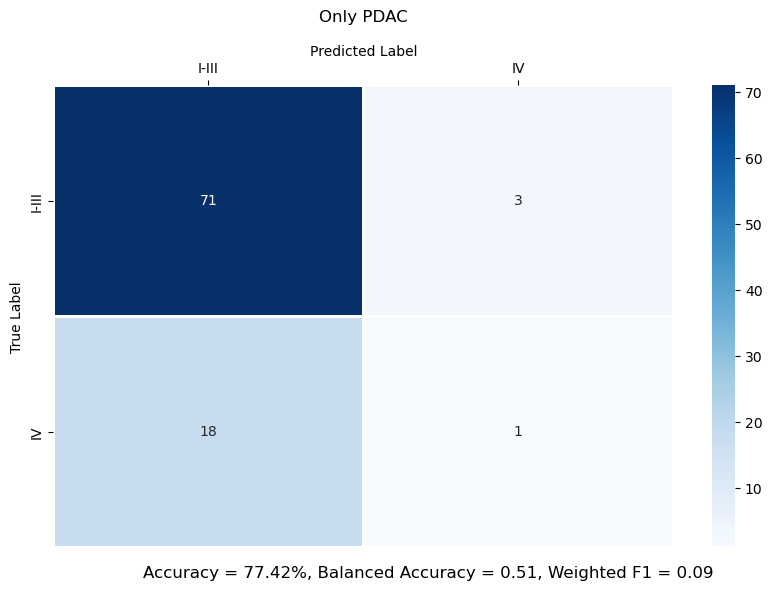

In [44]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only PDAC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'pdac_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))